In [1]:
# Imports :

import numpy as np
import pandas as pd
import string 
import pickle

# Plot : 
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost

from sklearn.model_selection import train_test_split, GridSearchCV
from skopt import BayesSearchCV

# Utils for encoding : 
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder

# Utils for regression : 
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, classification_report, make_scorer

# Utils for classification :
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, XGBRFClassifier, plot_importance
from sklearn.ensemble import HistGradientBoostingClassifier

# Utils for Metrics calculation : 
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, roc_curve
from metrics_utils import rewrite_keys, rapport_metrics_decision_tree
from sklearn.model_selection import cross_validate, cross_val_score, cross_val_predict

# Custom utils  
from Opti_utils.ML_utils import find_best_threshold, from_model_to_bst_trhld, custom_metrics, scores, compare_results,find_error
from Opti_utils.ML_utils import FP, TP, FN, TN, check_corr_col, filtre_list, fit_method, check_baseline, check_FP_FN, check_best_results
from Opti_utils.ML_utils import ML_opti_recueil, univariate_ml, sensi, speci, mix_sensi_speci, custom_metric
from Opti_utils.ML_utils import Binarisation, model_to_plot, clean_lists

# Ouverture des datas : 

In [2]:
recueil_imc  = pd.read_excel('./../Data/Recueil (1).xlsx').drop('Unnamed: 90', axis=1)
recueil_imc.shape

(181, 90)

In [3]:
# On enlève les colonnes liés a la chirurgie : 
liste_colonnes_chir = ['date.chir', 'chir.macro.lusd', 'chir.macro.lusg', 'chir.macro.torus',  'chir.macro.oma', 'chir.macro.uro', 'chir.macro.dig',  'chir.macro.superf', 'resec.lusd', 'resec.lusg', 'resec.torus', 'resec.autre']
for col_to_drop in liste_colonnes_chir:
    recueil_imc = recueil_imc.drop(col_to_drop, axis=1)
# Remplace les manquantes par un np.nan
recueil_imc.replace(['Na', 'NA', 'nan', 'Nan', 'NAN'], np.nan, inplace=True)
# n_ano en Index
recueil_imc = recueil_imc.set_index('Numéro anonymat')
recueil_imc.shape

(181, 77)

# Statistiques des variables continues : 

## Split des features et des targets : 

In [4]:
# recueil_imc.dropna(axis=0, inplace=True)
target = recueil_imc.iloc[:,-4:].copy()
features = recueil_imc.iloc[:,:-4].copy()

endometriose = target.loc[:,['anapath.lusd','anapath.lusg','anapath.torus']].sum(axis=1).apply(lambda x: Binarisation(x))

recueil_imc_endo = recueil_imc.copy()
recueil_imc_endo['endometriose'] = endometriose
recueil_imc_endo.shape

(181, 78)

## Calcul du % d'info manquantes : 

In [5]:
# La Gestité est corrélée avec la Parité

# Statistiques des variables catégorielles :

## Préparation des données : 

In [6]:
features_chir_ONE = pd.get_dummies(features.loc[:,'chir'], prefix='chir')
features_dsptype_ONE = pd.get_dummies(features.loc[:,'sf.dsp.type'].replace(0, 'aucun'), prefix='dsp.type')
features_enc = pd.concat([features.drop('chir', axis=1).drop('sf.dsp.type', axis=1), features_chir_ONE, features_dsptype_ONE], axis=1)

In [7]:
# split 
X_train, X_test, y_train, y_test = train_test_split(features_enc, endometriose, random_state=42, stratify=endometriose)



In [8]:
# split 
X_train2, X_test2, y_train2, y_test2 = train_test_split(features_enc, endometriose, random_state=42, stratify=endometriose)



In [9]:

scorer = make_scorer(custom_metric, greater_is_better=True)
mix_recall = make_scorer(mix_sensi_speci, greater_is_better=True)
sensibilite = make_scorer(sensi, greater_is_better=True)
specificite = make_scorer(speci, greater_is_better=True)
scorers = { 'speci': specificite, 'sensi' : sensibilite}

## Préparation du ML univarié : 

## Résultats : 

## Save Results

In [10]:
with open('./Data_generee/data.pkl', 'rb') as f1:
    dictionnary_list = pickle.load(f1)
    
liste_col_speci= clean_lists(dictionnary_list['specifite'])
liste_col_sensi = clean_lists(dictionnary_list['sensibilite'])
liste_col_mixte = clean_lists(dictionnary_list['moyenne'])

# Essais de ML avec les colonnes :

In [11]:
seed = 42 

In [12]:
# Params :
params_4 = {'bootstrap': [True, False],
            'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
            'min_samples_leaf': [1, 2, 4, 5, 6, 7],
            'min_samples_split': [2, 5, 10],
            'n_estimators': [100, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

## Base line : 

In [13]:
# On enlève les colonnes correlées : 
X_train_ = X_train.copy()
X_test_ = X_test.copy()

liste_to_drop = ['p','atcd.chir.endo','atcd.infertilite','sf.dsm','sf.dsp','ef.hormone.dsm','echo.oma','irm.xr']
for col in liste_to_drop:
    X_test_.drop(col, axis=1, inplace=True)
    X_train_.drop(col, axis=1, inplace=True)


inputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
X_train_rfc = inputer.fit_transform(X_train)
X_train_rfc = pd.DataFrame(X_train_rfc, columns=X_train.columns, index=X_train.index)
X_test_rfc = inputer.transform(X_test)
X_test_rfc = pd.DataFrame(X_test_rfc, columns=X_test.columns, index=X_test.index)


inputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
X_train_rfc_clean = inputer.fit_transform(X_train_)
X_train_rfc_clean = pd.DataFrame(X_train_rfc, columns=X_train.columns, index=X_train.index)
X_test_rfc_clean = inputer.transform(X_test_)
X_test_rfc_clean = pd.DataFrame(X_test_rfc, columns=X_test.columns, index=X_test.index)

### RF

In [14]:
# Init du modèle :
RFC_baseline = RandomForestClassifier(random_state=seed)
baseline_RF_cv = cross_validate(RFC_baseline, X_train_rfc_clean, y_train, cv=5, scoring=scorers, return_estimator =True)

print('sensi : ',round(baseline_RF_cv['test_sensi'].mean(), 2))
print('speci : ',round(baseline_RF_cv['test_speci'].mean(),2))

sensi :  0.66
speci :  0.5


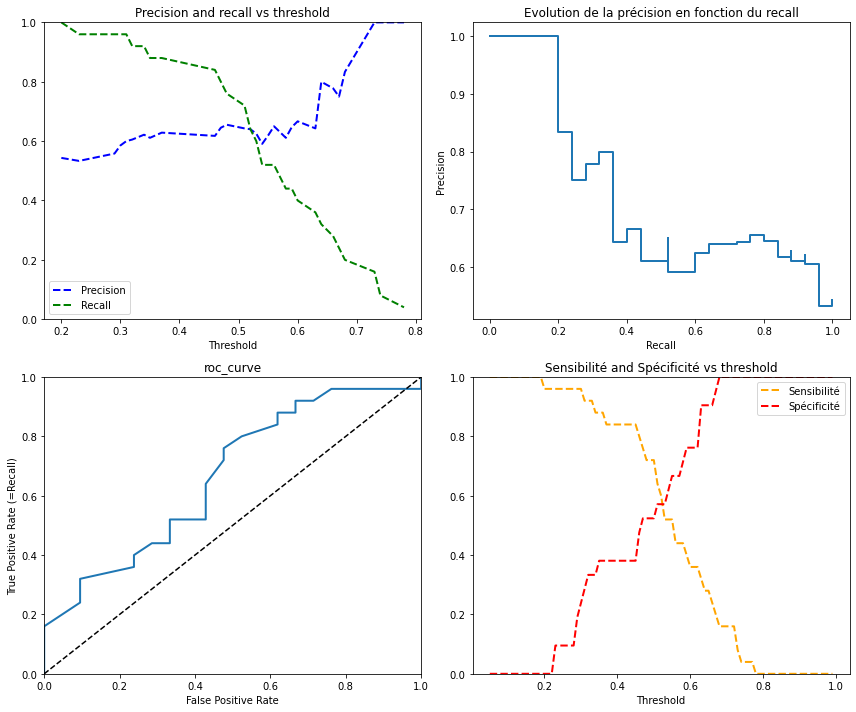

threshold = 0,5
Sensibilité :  0.72
Spécificité :  0.5238095238095238
_________________________________________________________
Best threshold : 0.63
Sensibilité : 0.32
Spécificité : 0.9047619047619048


In [15]:
tree_BL = RandomForestClassifier(random_state=seed)
tree_BL.fit(X_train_rfc_clean, y_train)
pred_BL = tree_BL.predict(X_test_rfc_clean)
model_to_plot(tree_BL, X_test_rfc_clean, y_test)
resultat_BL = pd.DataFrame(pd.Series(scores(y_test, pred_BL)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat_BL.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_BL.loc['specificité','XGB_BL_sensi'])
dict_ = from_model_to_bst_trhld(tree_BL, X_test_rfc_clean, y_test)
print('_________________________________________________________')
print('Best threshold :', dict_['best_threshold'])
print('Sensibilité :', dict_['scores']['sensibilite'])
print('Spécificité :', dict_['scores']['specificité'])

### <u>Optimisation Baseline</u> : 

##### sensibilité :

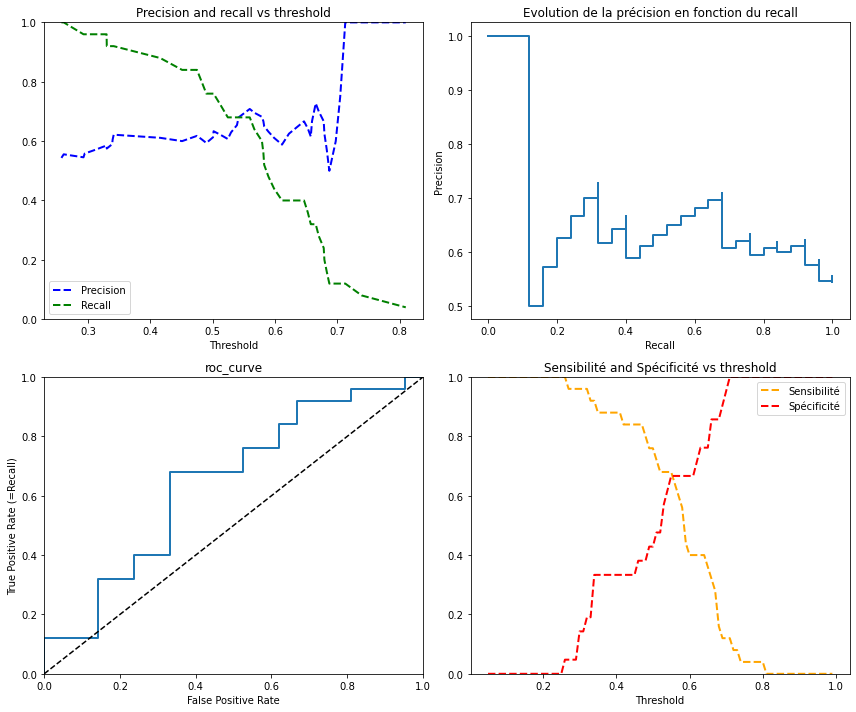

threshold = 0,5
Sensibilité :  0.76
Spécificité :  0.42857142857142855
_________________________________________________________
Best threshold : 0.66
Sensibilité : 0.32
Spécificité : 0.8571428571428571


In [16]:
RF_1 = RandomForestClassifier(random_state=seed)
gs_RF = BayesSearchCV(RF_1, params_4, scoring=sensibilite, random_state=seed)
gs_RF.fit(X_train_rfc_clean, y_train)
# Entrainement :
tree_opti_bl = RandomForestClassifier(**dict(gs_RF.best_params_),random_state=seed)
tree_opti_bl.fit(X_train_rfc_clean, y_train)
# Results :
pred_bl_1 = tree_opti_bl.predict(X_test_rfc_clean)
model_to_plot(tree_opti_bl, X_test_rfc_clean, y_test)
resultat_bl = pd.DataFrame(pd.Series(scores(y_test, pred_bl_1)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat_bl.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_bl.loc['specificité','XGB_BL_sensi'])
dict_bl = from_model_to_bst_trhld(tree_opti_bl, X_test_rfc_clean, y_test)
print('_________________________________________________________')
print('Best threshold :', dict_bl['best_threshold'])
print('Sensibilité :', dict_bl['scores']['sensibilite'])
print('Spécificité :', dict_bl['scores']['specificité'])

##### spécificité :

C:\Users\mamock\Anaconda3\envs\env_ENDOPATHS\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


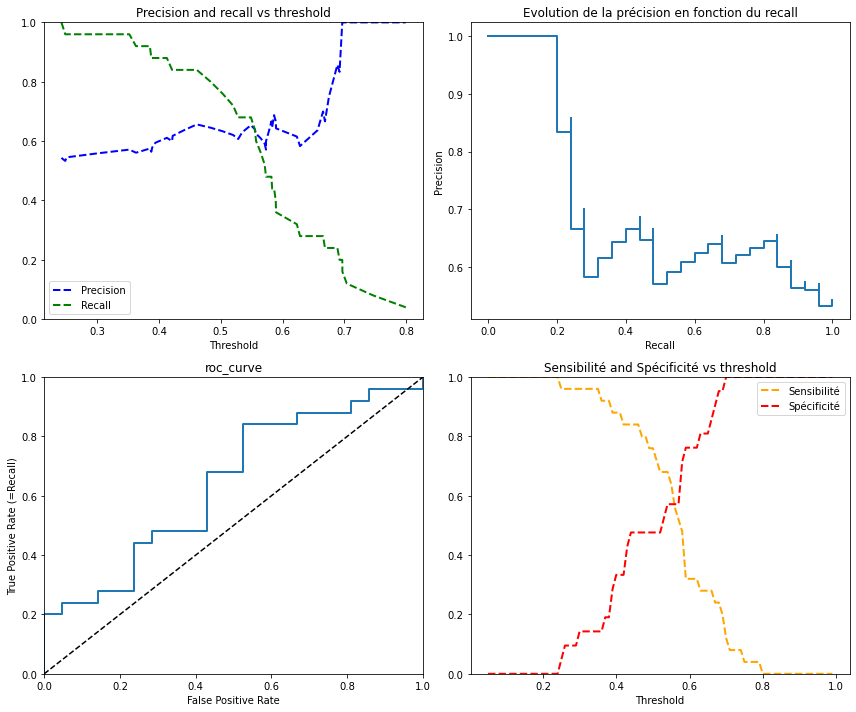

threshold = 0,5
Sensibilité :  0.76
Spécificité :  0.47619047619047616
_________________________________________________________
Best threshold : 0.66
Sensibilité : 0.28
Spécificité : 0.8571428571428571


In [17]:
RF_2 = RandomForestClassifier(random_state=seed)
gs_RF_2 = BayesSearchCV(RF_2, params_4, scoring=specificite,random_state=seed)
gs_RF_2.fit(X_train_rfc_clean, y_train)
# Entrainement :
tree_opti_2 = RandomForestClassifier(**dict(gs_RF_2.best_params_),random_state=seed)
tree_opti_2.fit(X_train_rfc_clean, y_train)
# Results :
pred_bl_2 = tree_opti_2.predict(X_test_rfc_clean)
model_to_plot(tree_opti_2, X_test_rfc_clean, y_test)
resultat_2 = pd.DataFrame(pd.Series(scores(y_test, pred_bl_2)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat_2.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_2.loc['specificité','XGB_BL_sensi'])
dict_2 = from_model_to_bst_trhld(tree_opti_2, X_test_rfc_clean, y_test)
print('_________________________________________________________')
print('Best threshold :', dict_2['best_threshold'])
print('Sensibilité :', dict_2['scores']['sensibilite'])
print('Spécificité :', dict_2['scores']['specificité'])

##### F1 :

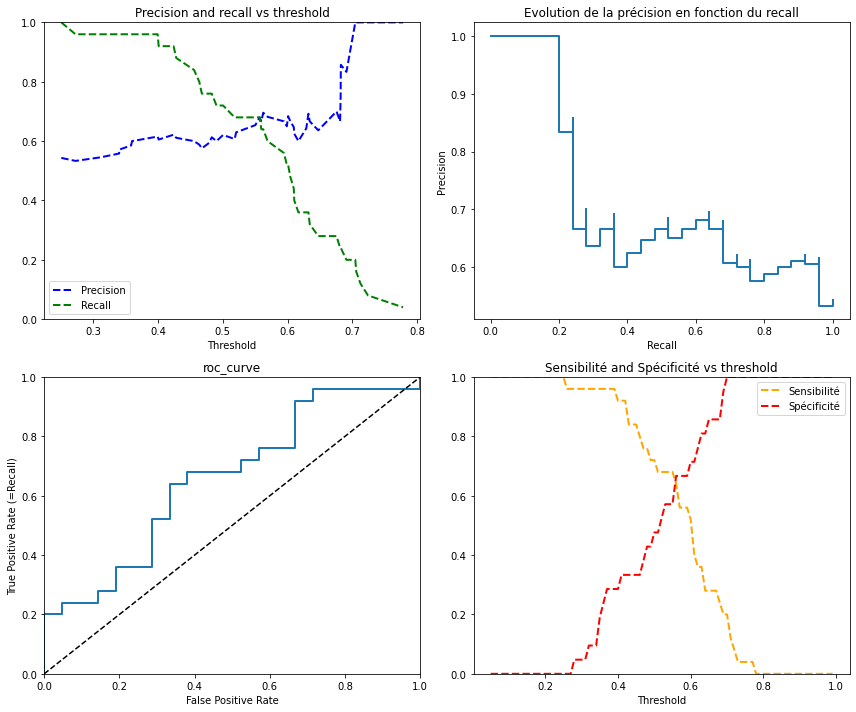

threshold = 0,5
Sensibilité :  0.72
Spécificité :  0.47619047619047616
_________________________________________________________
Best threshold : 0.63
Sensibilité : 0.36
Spécificité : 0.8095238095238095


In [18]:
RF_3 = RandomForestClassifier(random_state=seed)
gs_RF_3 = BayesSearchCV(RF_3, params_4, scoring='f1',random_state=seed)
gs_RF_3.fit(X_train_rfc_clean, y_train)
# Entrainement :
tree_opti_3 = RandomForestClassifier(**dict(gs_RF_3.best_params_),random_state=seed)
tree_opti_3.fit(X_train_rfc_clean, y_train)
# Results :
pred_bl_3 = tree_opti_3.predict(X_test_rfc_clean)
model_to_plot(tree_opti_3, X_test_rfc_clean, y_test)
resultat_3 = pd.DataFrame(pd.Series(scores(y_test, pred_bl_3)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat_3.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_3.loc['specificité','XGB_BL_sensi'])
dict_3 = from_model_to_bst_trhld(tree_opti_3, X_test_rfc_clean, y_test)
print('_________________________________________________________')
print('Best threshold :', dict_3['best_threshold'])
print('Sensibilité :', dict_3['scores']['sensibilite'])
print('Spécificité :', dict_3['scores']['specificité'])

##### Custom :

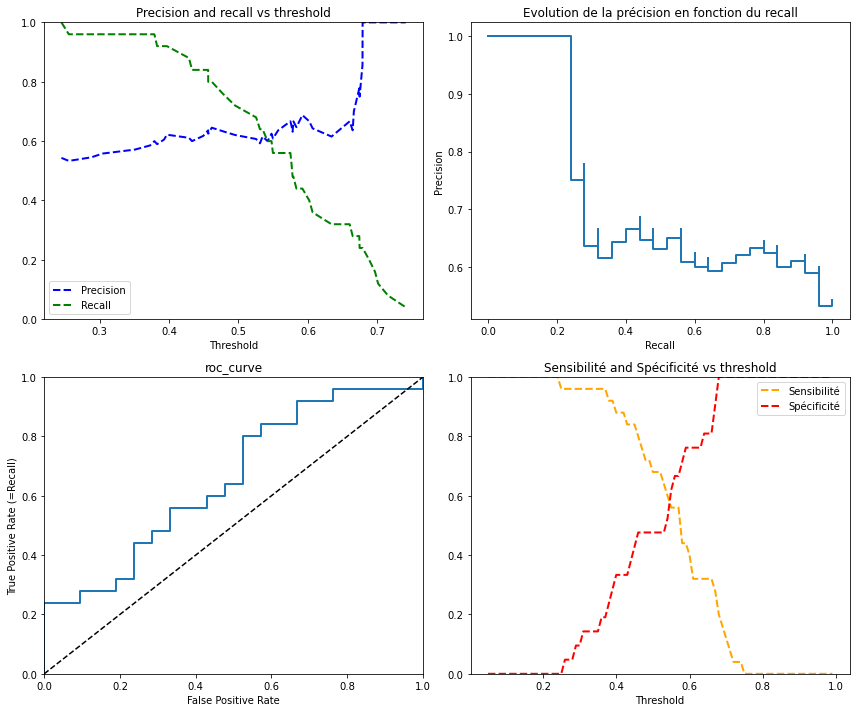

threshold = 0,5
Sensibilité :  0.68
Spécificité :  0.47619047619047616
_________________________________________________________
Best threshold : 0.64
Sensibilité : 0.32
Spécificité : 0.8095238095238095


In [19]:
RF_4 = RandomForestClassifier(random_state=seed)
gs_RF_4 = BayesSearchCV(RF_4, params_4, scoring=scorer,random_state=seed)
gs_RF_4.fit(X_train_rfc_clean, y_train)
# Entrainement :
tree_opti_4 = RandomForestClassifier(**dict(gs_RF_4.best_params_),random_state=seed)
tree_opti_4.fit(X_train_rfc_clean, y_train)
# Results :
pred_bl_4 = tree_opti_4.predict(X_test_rfc_clean)
model_to_plot(tree_opti_4, X_test_rfc_clean, y_test)
resultat_4 = pd.DataFrame(pd.Series(scores(y_test, pred_bl_4)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat_4.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_4.loc['specificité','XGB_BL_sensi'])
dict_4 = from_model_to_bst_trhld(tree_opti_4, X_test_rfc_clean, y_test)
print('_________________________________________________________')
print('Best threshold :', dict_4['best_threshold'])
print('Sensibilité :', dict_4['scores']['sensibilite'])
print('Spécificité :', dict_4['scores']['specificité'])

##### Mix :

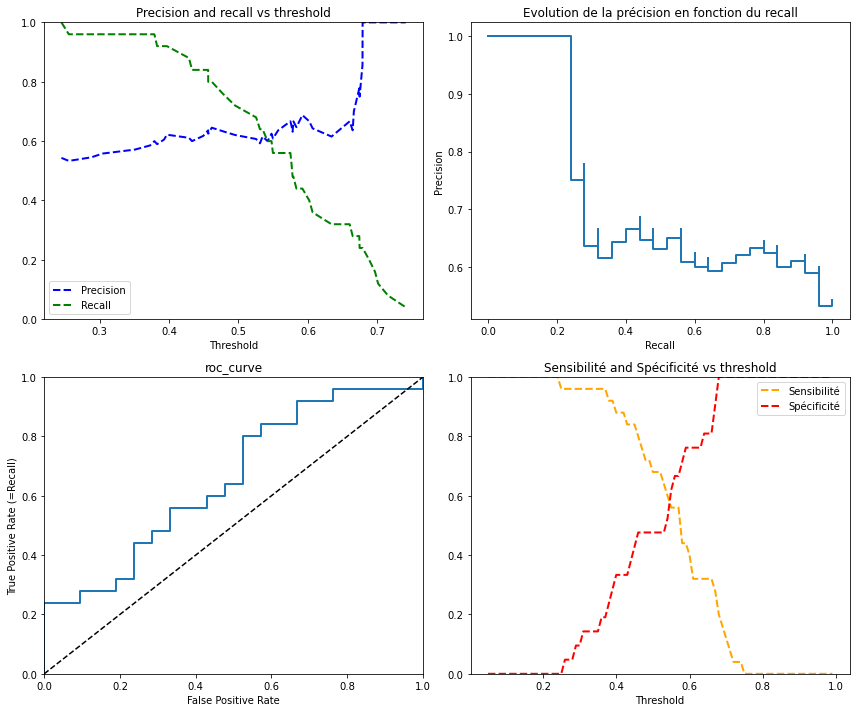

threshold = 0,5
Sensibilité :  0.68
Spécificité :  0.47619047619047616
_________________________________________________________
Best threshold : 0.64
Sensibilité : 0.32
Spécificité : 0.8095238095238095


In [20]:
RF_5 = RandomForestClassifier(random_state=seed)
gs_RF_5 = BayesSearchCV(RF_5, params_4, scoring=mix_recall,random_state=seed)
# Entrainement :
gs_RF_5.fit(X_train_rfc_clean, y_train)
# Entrainement :
tree_opti_5 = RandomForestClassifier(**dict(gs_RF_5.best_params_),random_state=seed)
tree_opti_5.fit(X_train_rfc_clean, y_train)
# Results :
pred_bl_5 = tree_opti_5.predict(X_test_rfc_clean)
model_to_plot(tree_opti_5, X_test_rfc_clean, y_test)
resultat_5 = pd.DataFrame(pd.Series(scores(y_test, pred_bl_5)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat_5.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_5.loc['specificité','XGB_BL_sensi'])
dict_5 = from_model_to_bst_trhld(tree_opti_5, X_test_rfc_clean, y_test)
print('_________________________________________________________')
print('Best threshold :', dict_5['best_threshold'])
print('Sensibilité :', dict_5['scores']['sensibilite'])
print('Spécificité :', dict_5['scores']['specificité'])

##### Average precision :

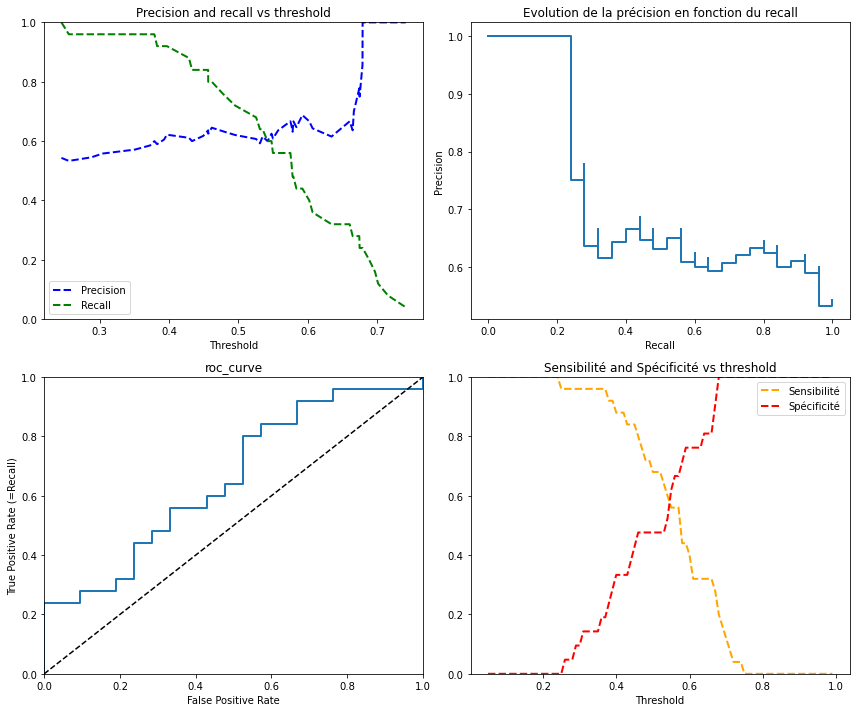

threshold = 0,5
Sensibilité :  0.68
Spécificité :  0.47619047619047616
_________________________________________________________
Best threshold : 0.64
Sensibilité : 0.32
Spécificité : 0.8095238095238095


In [21]:
RF_6 = RandomForestClassifier(random_state=seed)
gs_RF_6 = BayesSearchCV(RF_6, params_4, scoring=mix_recall,random_state=seed)
gs_RF_6.fit(X_train_rfc_clean, y_train)
# Entrainement :
tree_opti_6 = RandomForestClassifier(**dict(gs_RF_6.best_params_),random_state=seed)
tree_opti_6.fit(X_train_rfc_clean, y_train)
# Results :
pred_bl_6 = tree_opti_6.predict(X_test_rfc_clean)
model_to_plot(tree_opti_6, X_test_rfc_clean, y_test)
resultat_6 = pd.DataFrame(pd.Series(scores(y_test, pred_bl_6)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat_6.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_6.loc['specificité','XGB_BL_sensi'])
dict_6 = from_model_to_bst_trhld(tree_opti_6, X_test_rfc_clean, y_test)
print('_________________________________________________________')
print('Best threshold :', dict_6['best_threshold'])
print('Sensibilité :', dict_6['scores']['sensibilite'])
print('Spécificité :', dict_6['scores']['specificité'])

## ML sensibilité : 

In [22]:
# Init du modèle :
RFC_baseline_sensi = RandomForestClassifier(random_state=seed)

RF_sensi_cv = cross_validate(RFC_baseline_sensi, X_train_rfc.loc[:,liste_col_sensi], y_train, cv=5, scoring=scorers, return_estimator =True)

print('sensi : ',round(RF_sensi_cv['test_sensi'].mean(), 2))
print('speci : ',round(RF_sensi_cv['test_speci'].mean(),2))

sensi :  0.57
speci :  0.43


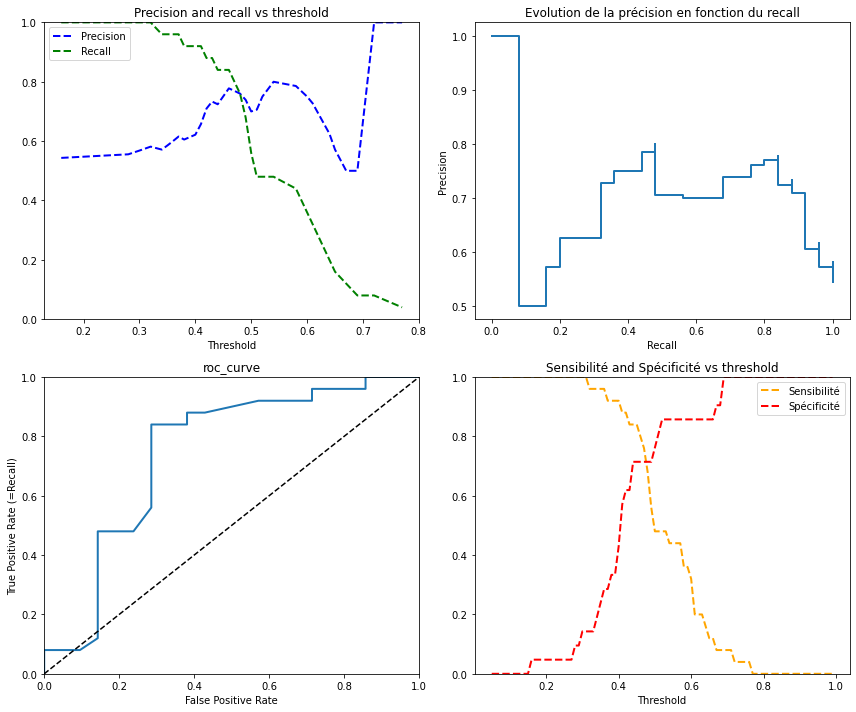

threshold = 0,5
Sensibilité :  0.48
Spécificité :  0.7619047619047619
_________________________________________________________
Best threshold : 0.52
Sensibilité : 0.48
Spécificité : 0.8571428571428571


In [23]:
tree_sensi = RandomForestClassifier(random_state=seed)
tree_sensi.fit(X_train_rfc.loc[:,liste_col_sensi], y_train)
pred_sensi = tree_sensi.predict(X_test_rfc.loc[:,liste_col_sensi])
model_to_plot(tree_sensi, X_test_rfc.loc[:,liste_col_sensi], y_test)
resultat_sensi = pd.DataFrame(pd.Series(scores(y_test, pred_sensi)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat_sensi.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_sensi.loc['specificité','XGB_BL_sensi'])
dict_sensi = from_model_to_bst_trhld(tree_sensi, X_test_rfc.loc[:,liste_col_sensi], y_test)
print('_________________________________________________________')
print('Best threshold :', dict_sensi['best_threshold'])
print('Sensibilité :', dict_sensi['scores']['sensibilite'])
print('Spécificité :', dict_sensi['scores']['specificité'])

### Opti : 

#####  Sensibilité :

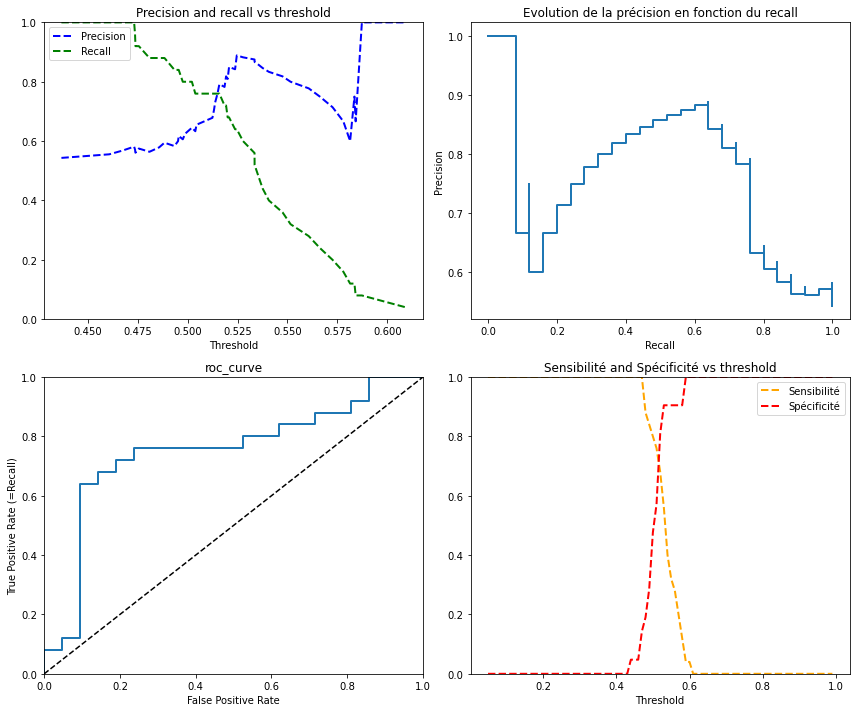

threshold = 0,5
Sensibilité :  0.8
Spécificité :  0.47619047619047616
_________________________________________________________
Best threshold : 0.52
Sensibilité : 0.68
Spécificité : 0.8095238095238095


In [24]:
RF_1 = RandomForestClassifier(random_state=seed)
gs_RF_1 = BayesSearchCV(RF_1, params_4, scoring=sensibilite,random_state=seed)
# Entrainement :
gs_RF_1.fit(X_train_rfc.loc[:,liste_col_sensi], y_train)
tree_sensi_1 = RandomForestClassifier(**dict(gs_RF_1.best_params_),random_state=seed)
tree_sensi_1.fit(X_train_rfc.loc[:,liste_col_sensi], y_train)
# Results :
pred_sensi_1 = tree_sensi_1.predict(X_test_rfc.loc[:,liste_col_sensi])
model_to_plot(tree_sensi_1, X_test_rfc.loc[:,liste_col_sensi], y_test)
resultat_sensi_1 = pd.DataFrame(pd.Series(scores(y_test, pred_sensi_1)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat_sensi_1.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_sensi_1.loc['specificité','XGB_BL_sensi'])
dict_sensi_1 = from_model_to_bst_trhld(tree_sensi_1, X_test_rfc.loc[:,liste_col_sensi], y_test)
print('_________________________________________________________')
print('Best threshold :', dict_sensi_1['best_threshold'])
print('Sensibilité :', dict_sensi_1['scores']['sensibilite'])
print('Spécificité :', dict_sensi_1['scores']['specificité'])

#####  Spécificité :

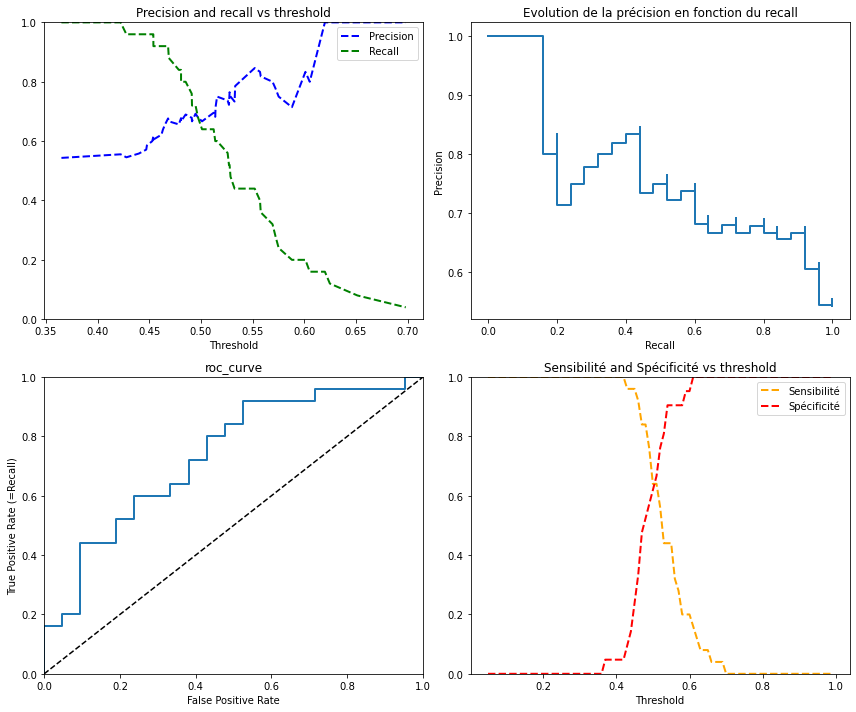

threshold = 0,5
Sensibilité :  0.64
Spécificité :  0.6190476190476191
_________________________________________________________
Best threshold : 0.54
Sensibilité : 0.44
Spécificité : 0.9047619047619048


In [25]:
RF_2 = RandomForestClassifier(random_state=seed)
gs_RF_2 = BayesSearchCV(RF_2, params_4, scoring=specificite,random_state=seed)
# Entrainement :
gs_RF_2.fit(X_train_rfc.loc[:,liste_col_speci], y_train)
tree_sensi_2 = RandomForestClassifier(**dict(gs_RF_2.best_params_),random_state=seed)
tree_sensi_2.fit(X_train_rfc.loc[:,liste_col_sensi], y_train)
# Results :
pred_sensi_2 = tree_sensi_2.predict(X_test_rfc.loc[:,liste_col_sensi])
model_to_plot(tree_sensi_2, X_test_rfc.loc[:,liste_col_sensi], y_test)
resultat_sensi_2 = pd.DataFrame(pd.Series(scores(y_test, pred_sensi_2)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat_sensi_2.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_sensi_2.loc['specificité','XGB_BL_sensi'])
dict_sensi_2 = from_model_to_bst_trhld(tree_sensi_2, X_test_rfc.loc[:,liste_col_sensi], y_test)
print('_________________________________________________________')
print('Best threshold :', dict_sensi_2['best_threshold'])
print('Sensibilité :', dict_sensi_2['scores']['sensibilite'])
print('Spécificité :', dict_sensi_2['scores']['specificité'])

#####  F1 :

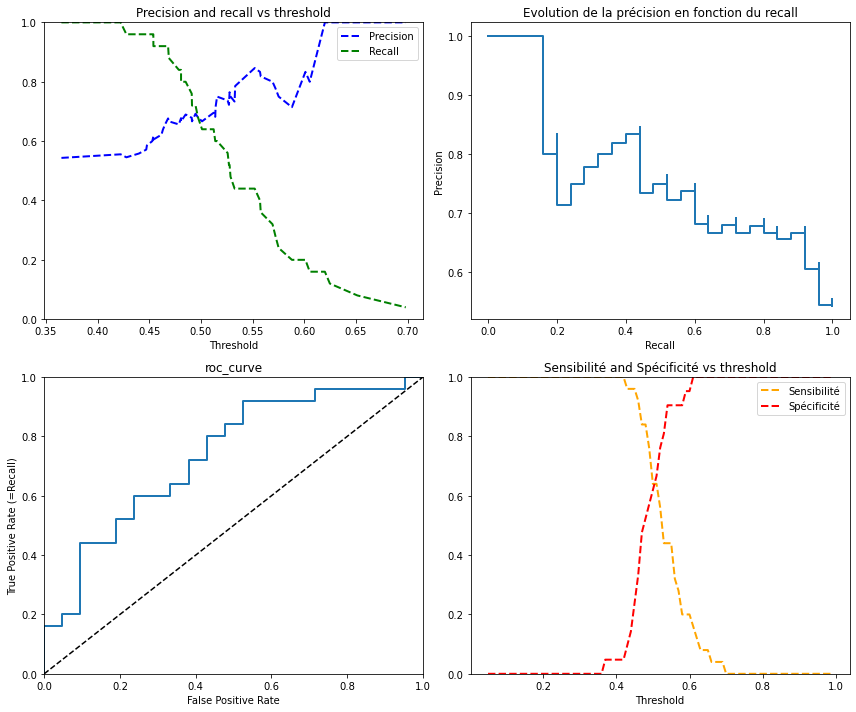

threshold = 0,5
Sensibilité :  0.64
Spécificité :  0.6190476190476191
_________________________________________________________
Best threshold : 0.54
Sensibilité : 0.44
Spécificité : 0.9047619047619048


In [26]:
RF_3 = RandomForestClassifier(random_state=seed)
gs_RF_3 = BayesSearchCV(RF_3, params_4, scoring='f1',random_state=seed)
# Entrainement :
gs_RF_3.fit(X_train_rfc.loc[:,liste_col_speci], y_train)
tree_sensi_3 = RandomForestClassifier(**dict(gs_RF_3.best_params_),random_state=seed)
tree_sensi_3.fit(X_train_rfc.loc[:,liste_col_sensi], y_train)
# Results :
pred_sensi_3 = tree_sensi_3.predict(X_test_rfc.loc[:,liste_col_sensi])
model_to_plot(tree_sensi_3, X_test_rfc.loc[:,liste_col_sensi], y_test)
resultat_sensi_3 = pd.DataFrame(pd.Series(scores(y_test, pred_sensi_3)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat_sensi_3.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_sensi_3.loc['specificité','XGB_BL_sensi'])
dict_sensi_3 = from_model_to_bst_trhld(tree_sensi_3, X_test_rfc.loc[:,liste_col_sensi], y_test)
print('_________________________________________________________')
print('Best threshold :', dict_sensi_3['best_threshold'])
print('Sensibilité :', dict_sensi_3['scores']['sensibilite'])
print('Spécificité :', dict_sensi_3['scores']['specificité'])

#####  Custom :

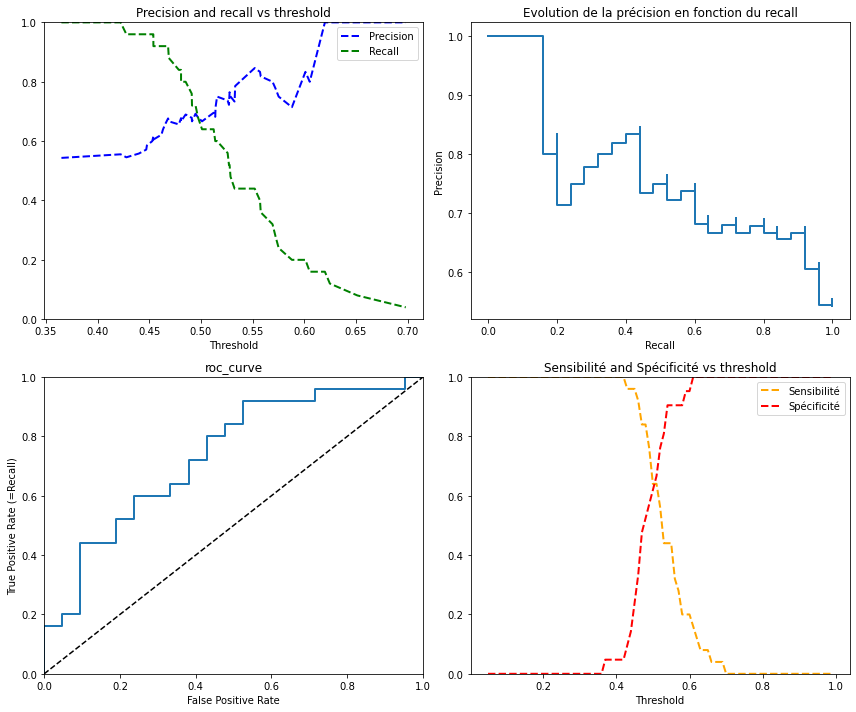

threshold = 0,5
Sensibilité :  0.64
Spécificité :  0.6190476190476191
_________________________________________________________
Best threshold : 0.54
Sensibilité : 0.44
Spécificité : 0.9047619047619048


In [27]:
RF_4 = RandomForestClassifier(random_state=seed)
gs_RF_4 = BayesSearchCV(RF_4, params_4, scoring=scorer,random_state=seed)
# Entrainement :
gs_RF_4.fit(X_train_rfc.loc[:,liste_col_speci], y_train)
tree_sensi_4 = RandomForestClassifier(**dict(gs_RF_4.best_params_),random_state=seed)
tree_sensi_4.fit(X_train_rfc.loc[:,liste_col_sensi], y_train)
# Results :
pred_sensi_4 = tree_sensi_4.predict(X_test_rfc.loc[:,liste_col_sensi])
model_to_plot(tree_sensi_4, X_test_rfc.loc[:,liste_col_sensi], y_test)
resultat_sensi_4 = pd.DataFrame(pd.Series(scores(y_test, pred_sensi_4)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat_sensi_4.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_sensi_4.loc['specificité','XGB_BL_sensi'])
dict_sensi_4 = from_model_to_bst_trhld(tree_sensi_4, X_test_rfc.loc[:,liste_col_sensi], y_test)
print('_________________________________________________________')
print('Best threshold :', dict_sensi_4['best_threshold'])
print('Sensibilité :', dict_sensi_4['scores']['sensibilite'])
print('Spécificité :', dict_sensi_4['scores']['specificité'])

##### Mix :

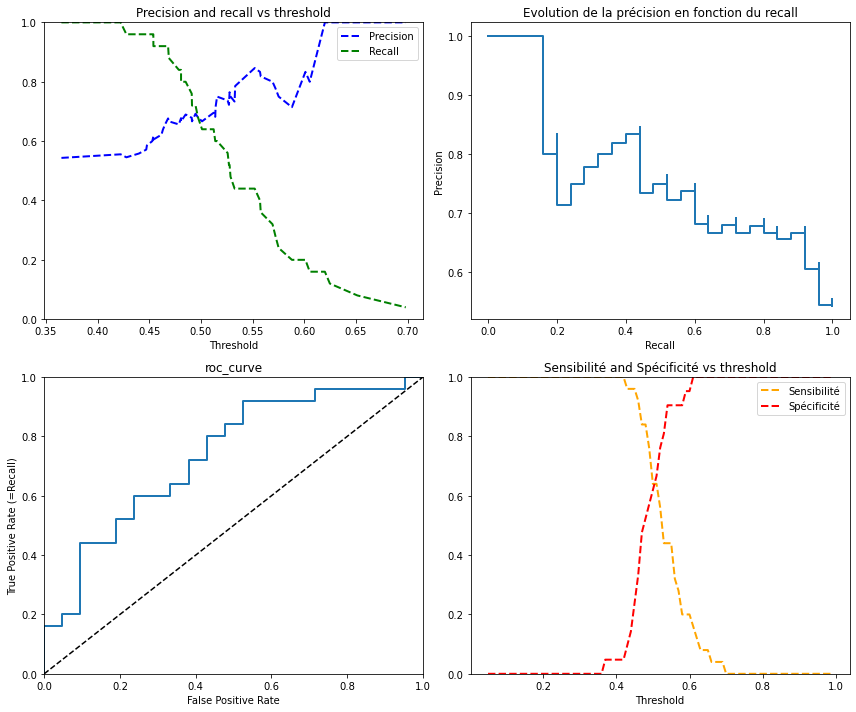

threshold = 0,5
Sensibilité :  0.64
Spécificité :  0.6190476190476191
_________________________________________________________
Best threshold : 0.54
Sensibilité : 0.44
Spécificité : 0.9047619047619048


In [28]:
RF_5 = RandomForestClassifier(random_state=seed)
gs_RF_5 = BayesSearchCV(RF_5, params_4, scoring=mix_recall,random_state=seed)
# Entrainement :
gs_RF_5.fit(X_train_rfc.loc[:,liste_col_speci], y_train)
tree_sensi_5 = RandomForestClassifier(**dict(gs_RF_5.best_params_),random_state=seed)
tree_sensi_5.fit(X_train_rfc.loc[:,liste_col_sensi], y_train)
# Results :
pred_sensi_5 = tree_sensi_5.predict(X_test_rfc.loc[:,liste_col_sensi])
model_to_plot(tree_sensi_5, X_test_rfc.loc[:,liste_col_sensi], y_test)
resultat_sensi_5 = pd.DataFrame(pd.Series(scores(y_test, pred_sensi_5)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat_sensi_5.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_sensi_5.loc['specificité','XGB_BL_sensi'])
dict_sensi_5 = from_model_to_bst_trhld(tree_sensi_5, X_test_rfc.loc[:,liste_col_sensi], y_test)
print('_________________________________________________________')
print('Best threshold :', dict_sensi_5['best_threshold'])
print('Sensibilité :', dict_sensi_5['scores']['sensibilite'])
print('Spécificité :', dict_sensi_5['scores']['specificité'])

##### Average precision :

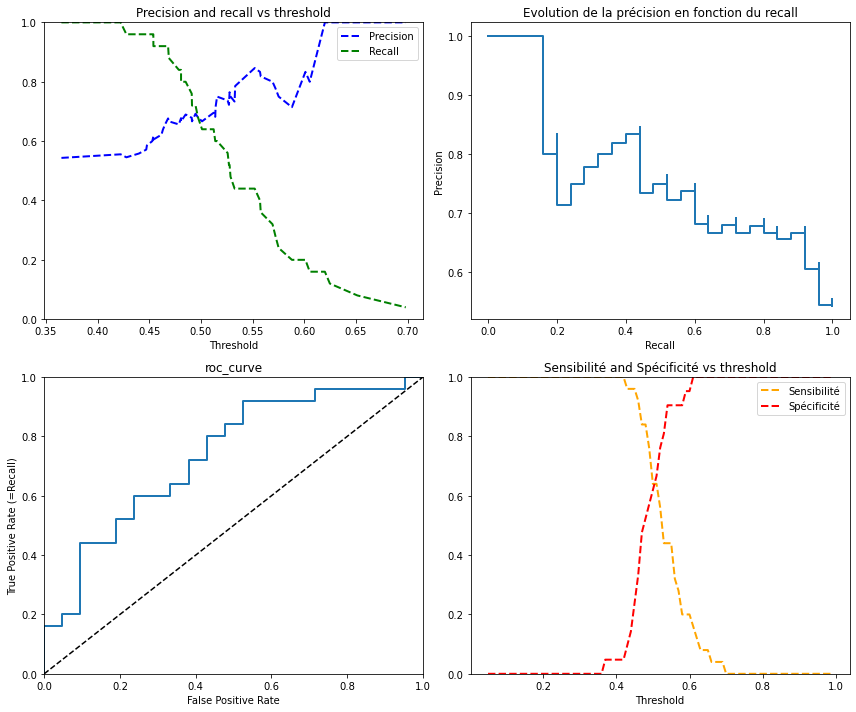

threshold = 0,5
Sensibilité :  0.64
Spécificité :  0.6190476190476191
_________________________________________________________
Best threshold : 0.54
Sensibilité : 0.44
Spécificité : 0.9047619047619048


In [29]:
RF_6 = RandomForestClassifier(random_state=seed)
gs_RF_6 = BayesSearchCV(RF_6, params_4, scoring='average_precision',random_state=seed)
# Entrainement :
gs_RF_6.fit(X_train_rfc.loc[:,liste_col_speci], y_train)
tree_sensi_6 = RandomForestClassifier(**dict(gs_RF_6.best_params_),random_state=seed)
tree_sensi_6.fit(X_train_rfc.loc[:,liste_col_sensi], y_train)
# Results :
pred_sensi_6 = tree_sensi_6.predict(X_test_rfc.loc[:,liste_col_sensi])
model_to_plot(tree_sensi_6, X_test_rfc.loc[:,liste_col_sensi], y_test)
resultat_sensi_6 = pd.DataFrame(pd.Series(scores(y_test, pred_sensi_6)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat_sensi_6.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_sensi_6.loc['specificité','XGB_BL_sensi'])
dict_sensi_6 = from_model_to_bst_trhld(tree_sensi_6, X_test_rfc.loc[:,liste_col_sensi], y_test)
print('_________________________________________________________')
print('Best threshold :', dict_sensi_6['best_threshold'])
print('Sensibilité :', dict_sensi_6['scores']['sensibilite'])
print('Spécificité :', dict_sensi_6['scores']['specificité'])

## ML speci

## Base line : 

In [30]:
# Init du modèle :
RFC_speci = RandomForestClassifier(random_state=seed)

# Préparation des datas :

speci_RF_cv = cross_validate(RFC_speci, X_train_rfc.loc[:,liste_col_speci], y_train, cv=5, scoring=scorers, return_estimator =True)

print('sensi : ',round(speci_RF_cv['test_sensi'].mean(), 2))
print('speci : ',round(speci_RF_cv['test_speci'].mean(),2))

sensi :  0.67
speci :  0.64


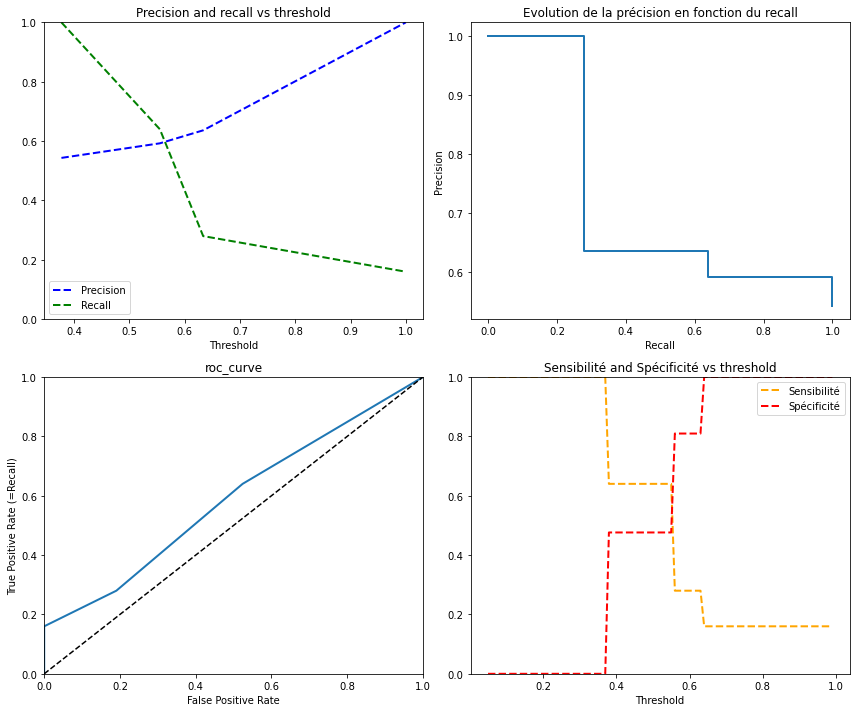

threshold = 0,5
Sensibilité :  0.64
Spécificité :  0.47619047619047616
_________________________________________________________
Best threshold : 0.56
Sensibilité : 0.28
Spécificité : 0.8095238095238095


In [32]:
RFC_speci_ = RandomForestClassifier(random_state=seed)
RFC_speci_.fit(X_train_rfc.loc[:,liste_col_speci], y_train)
pred_speci_ = RFC_speci_.predict(X_test_rfc.loc[:,liste_col_speci])
model_to_plot(RFC_speci_, X_test_rfc.loc[:,liste_col_speci], y_test)
resultat_speci_ = pd.DataFrame(pd.Series(scores(y_test, pred_speci_)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat_speci_.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_speci_.loc['specificité','XGB_BL_sensi'])
dict_speci = from_model_to_bst_trhld(RFC_speci_, X_test_rfc.loc[:,liste_col_speci], y_test)
print('_________________________________________________________')
print('Best threshold :', dict_speci['best_threshold'])
print('Sensibilité :', dict_speci['scores']['sensibilite'])
print('Spécificité :', dict_speci['scores']['specificité'])

### Optimisation : 

##### sensibilité : 

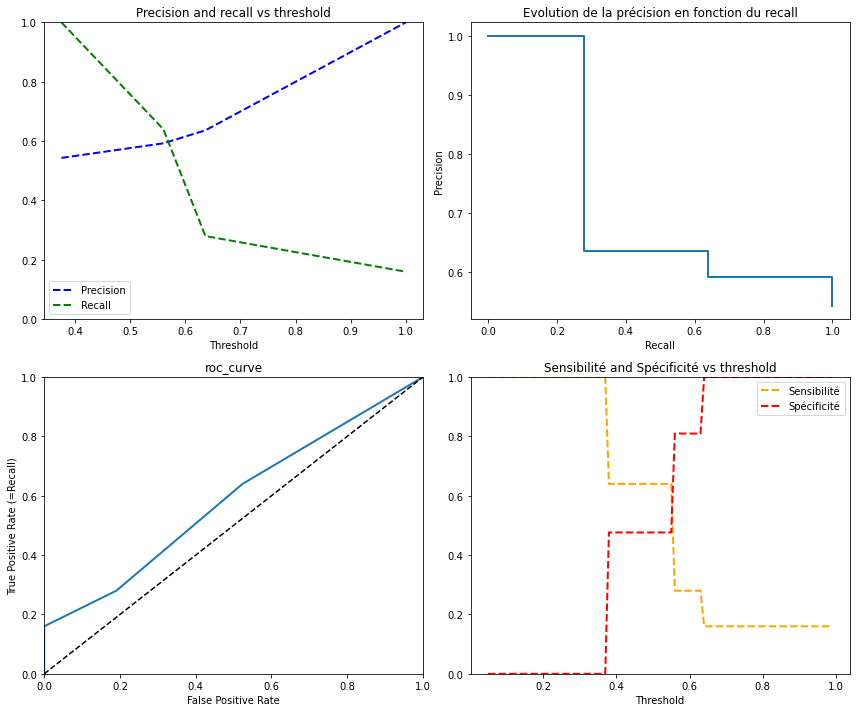

threshold = 0,5
Sensibilité :  0.64
Spécificité :  0.47619047619047616
_________________________________________________________
Best threshold : 0.56
Sensibilité : 0.28
Spécificité : 0.8095238095238095


In [34]:
RFC_speci_3_opti = RandomForestClassifier(random_state=seed)
opt_testbis = BayesSearchCV(estimator=RFC_speci_3_opti, search_spaces=params_4, scoring = 'recall', n_iter=32, random_state=seed)
opt_testbis.fit(X_train_rfc.loc[:,liste_col_speci], y_train)
tree_speci_1 = RandomForestClassifier(**dict(opt_testbis.best_params_),random_state=seed)
tree_speci_1.fit(X_train_rfc.loc[:,liste_col_speci], y_train)
pred_speci_1 = tree_speci_1.predict(X_test_rfc.loc[:,liste_col_speci])
model_to_plot(tree_speci_1, X_test_rfc.loc[:,liste_col_speci], y_test)
resultat_speci_1 = pd.DataFrame(pd.Series(scores(y_test, pred_speci_1)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat_speci_1.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_speci_1.loc['specificité','XGB_BL_sensi'])
dict_speci_1 = from_model_to_bst_trhld(tree_speci_1, X_test_rfc.loc[:,liste_col_speci], y_test)
print('_________________________________________________________')
print('Best threshold :', dict_speci_1['best_threshold'])
print('Sensibilité :', dict_speci_1['scores']['sensibilite'])
print('Spécificité :', dict_speci_1['scores']['specificité'])

##### Specificité : 

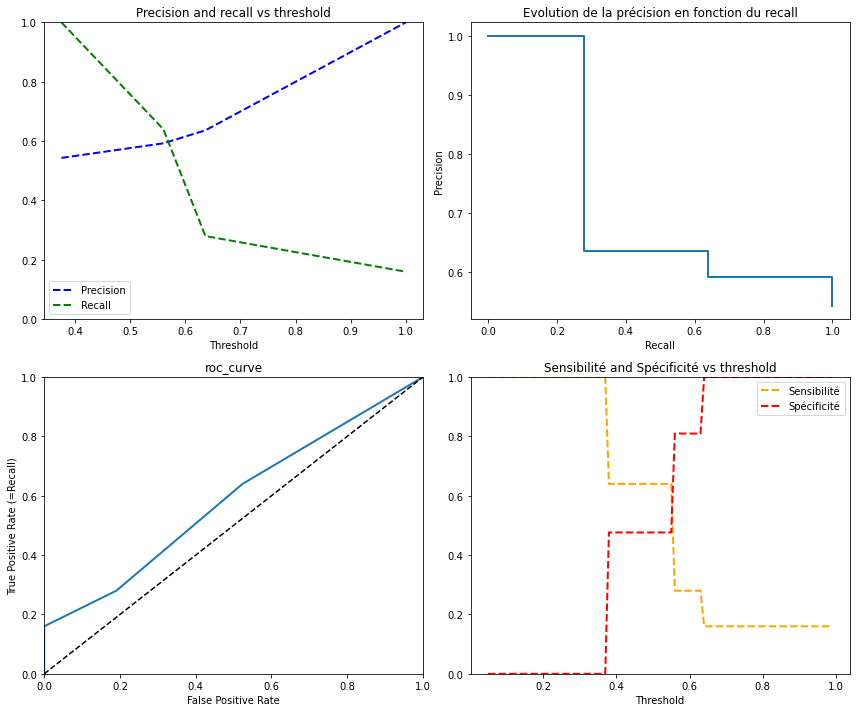

threshold = 0,5
Sensibilité :  0.64
Spécificité :  0.47619047619047616
_________________________________________________________
Best threshold : 0.56
Sensibilité : 0.28
Spécificité : 0.8095238095238095


In [36]:
RFC_speci2 = RandomForestClassifier(random_state=seed)
opt_speci2 = BayesSearchCV(estimator=RFC_speci_3_opti, search_spaces=params_4, scoring = specificite, n_iter=32, random_state=seed)
opt_speci2.fit(X_train_rfc.loc[:,liste_col_speci], y_train)
tree_speci_2 = RandomForestClassifier(**dict(opt_speci2.best_params_),random_state=seed)
tree_speci_2.fit(X_train_rfc.loc[:,liste_col_speci], y_train)
pred_speci_2 = tree_speci_2.predict(X_test_rfc.loc[:,liste_col_speci])
model_to_plot(tree_speci_2, X_test_rfc.loc[:,liste_col_speci], y_test)
resultat_speci_2 = pd.DataFrame(pd.Series(scores(y_test, pred_speci_2)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat_speci_2.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_speci_2.loc['specificité','XGB_BL_sensi'])
dict_speci_2 = from_model_to_bst_trhld(tree_speci_2, X_test_rfc.loc[:,liste_col_speci], y_test)
print('_________________________________________________________')
print('Best threshold :', dict_speci_2['best_threshold'])
print('Sensibilité :', dict_speci_2['scores']['sensibilite'])
print('Spécificité :', dict_speci_2['scores']['specificité'])

##### F1 :

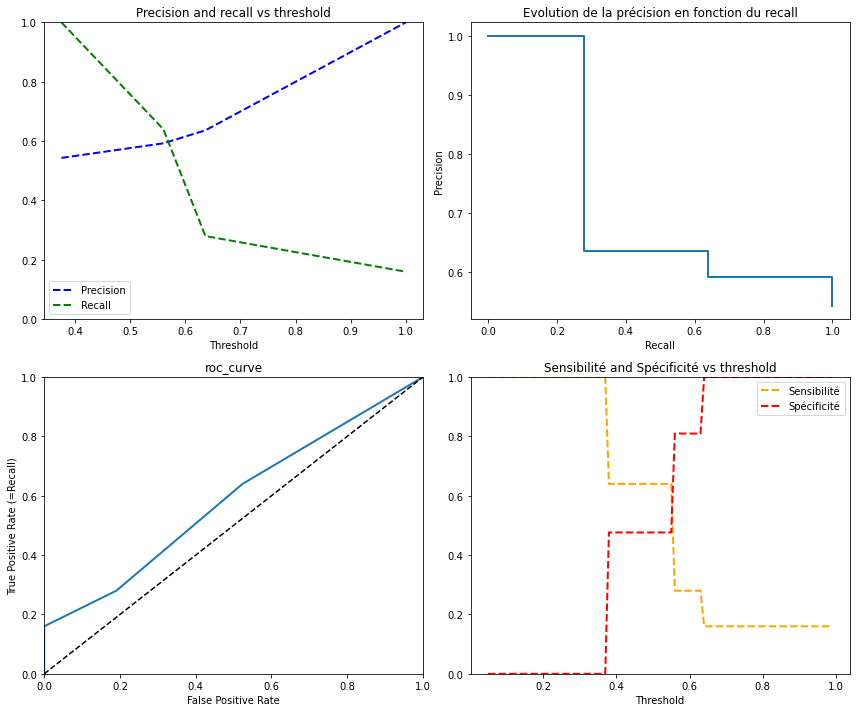

threshold = 0,5
Sensibilité :  0.64
Spécificité :  0.47619047619047616
_________________________________________________________
Best threshold : 0.56
Sensibilité : 0.28
Spécificité : 0.8095238095238095


In [39]:
RFC_speci_4_opti = RandomForestClassifier(random_state=seed)
opt_testbis_ = BayesSearchCV(estimator=RFC_speci_4_opti, search_spaces=params_4, scoring = 'f1', n_iter=32, random_state=seed)
opt_testbis_.fit(X_train_rfc.loc[:,liste_col_speci], y_train)
tree_speci_3 = RandomForestClassifier(**dict(opt_testbis_.best_params_),random_state=seed)
tree_speci_3.fit(X_train_rfc.loc[:,liste_col_speci], y_train)
pred_speci_3 = tree_speci_3.predict(X_test_rfc.loc[:,liste_col_speci])
model_to_plot(tree_speci_3, X_test_rfc.loc[:,liste_col_speci], y_test)
resultat_speci_3 = pd.DataFrame(pd.Series(scores(y_test, pred_speci_3)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat_speci_3.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_speci_3.loc['specificité','XGB_BL_sensi'])
dict_speci_3 = from_model_to_bst_trhld(tree_speci_3, X_test_rfc.loc[:,liste_col_speci], y_test)
print('_________________________________________________________')
print('Best threshold :', dict_speci_3['best_threshold'])
print('Sensibilité :', dict_speci_3['scores']['sensibilite'])
print('Spécificité :', dict_speci_3['scores']['specificité'])

##### Custom :

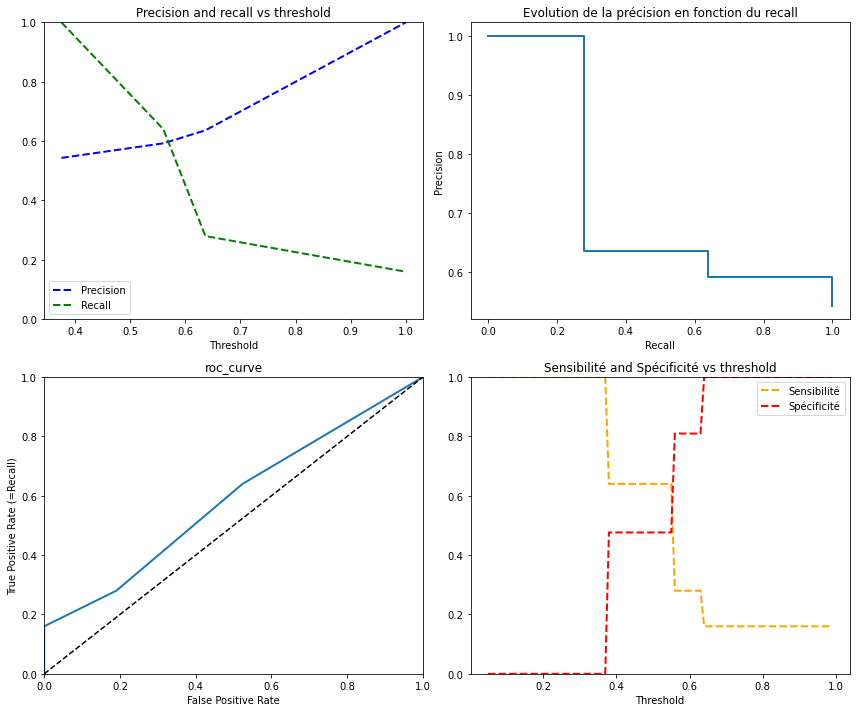

threshold = 0,5
Sensibilité :  0.64
Spécificité :  0.47619047619047616
_________________________________________________________
Best threshold : 0.56
Sensibilité : 0.28
Spécificité : 0.8095238095238095


In [40]:
RFC_speci_1_opti = RandomForestClassifier(random_state=seed)
opt_test_cust = BayesSearchCV(estimator=RFC_speci_1_opti, search_spaces=params_4, scoring = scorer, n_iter=32, random_state=seed)
opt_test_cust.fit(X_train_rfc.loc[:,liste_col_speci], y_train)
tree_speci_4 = RandomForestClassifier(**dict(opt_test_cust.best_params_),random_state=seed)
tree_speci_4.fit(X_train_rfc.loc[:,liste_col_speci], y_train)
pred_speci_4 = tree_speci_4.predict(X_test_rfc.loc[:,liste_col_speci])
model_to_plot(tree_speci_4, X_test_rfc.loc[:,liste_col_speci], y_test)
resultat_speci_4 = pd.DataFrame(pd.Series(scores(y_test, pred_speci_4)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat_speci_4.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_speci_4.loc['specificité','XGB_BL_sensi'])
dict_speci_4 = from_model_to_bst_trhld(tree_speci_4, X_test_rfc.loc[:,liste_col_speci], y_test)
print('_________________________________________________________')
print('Best threshold :', dict_speci_4['best_threshold'])
print('Sensibilité :', dict_speci_4['scores']['sensibilite'])
print('Spécificité :', dict_speci_4['scores']['specificité'])

##### Mix :

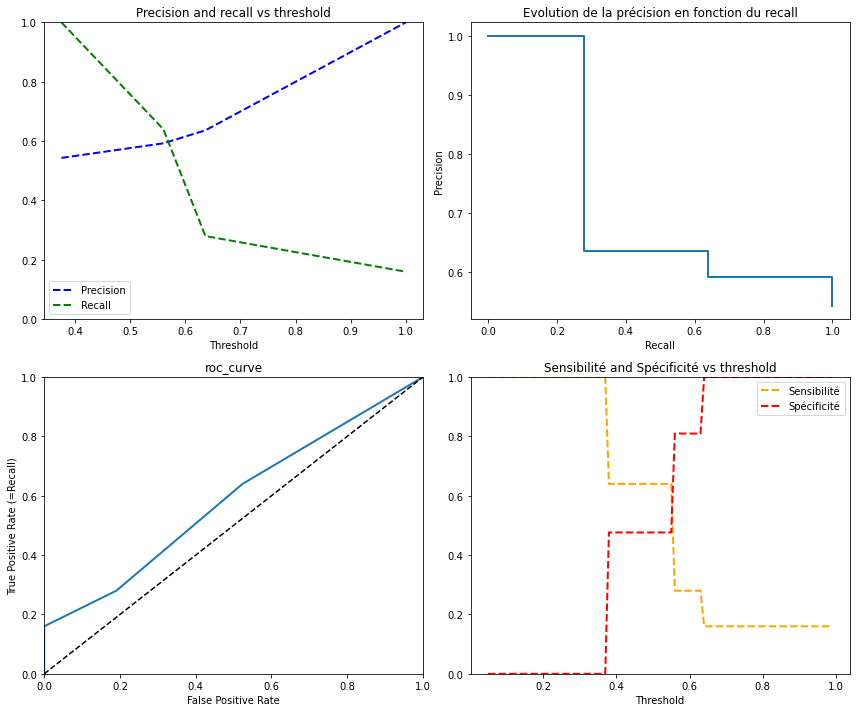

threshold = 0,5
Sensibilité :  0.64
Spécificité :  0.47619047619047616
_________________________________________________________
Best threshold : 0.56
Sensibilité : 0.28
Spécificité : 0.8095238095238095


In [41]:
RFC_speci_2_opti = RandomForestClassifier(random_state=seed)
opt_testbis5_ = BayesSearchCV(estimator=RFC_speci_2_opti, search_spaces=params_4, scoring = mix_recall, n_iter=32, random_state=seed)
opt_testbis5_.fit(X_train_rfc.loc[:,liste_col_speci], y_train)
tree_speci_5 = RandomForestClassifier(**dict(opt_testbis5_.best_params_),random_state=seed)
tree_speci_5.fit(X_train_rfc.loc[:,liste_col_speci], y_train)
pred_speci_5 = tree_speci_5.predict(X_test_rfc.loc[:,liste_col_speci])
model_to_plot(tree_speci_4, X_test_rfc.loc[:,liste_col_speci], y_test)
resultat_speci_5 = pd.DataFrame(pd.Series(scores(y_test, pred_speci_5)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat_speci_5.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_speci_5.loc['specificité','XGB_BL_sensi'])
dict_speci_5 = from_model_to_bst_trhld(tree_speci_5, X_test_rfc.loc[:,liste_col_speci], y_test)
print('_________________________________________________________')
print('Best threshold :', dict_speci_5['best_threshold'])
print('Sensibilité :', dict_speci_5['scores']['sensibilite'])
print('Spécificité :', dict_speci_5['scores']['specificité'])

##### average precision :

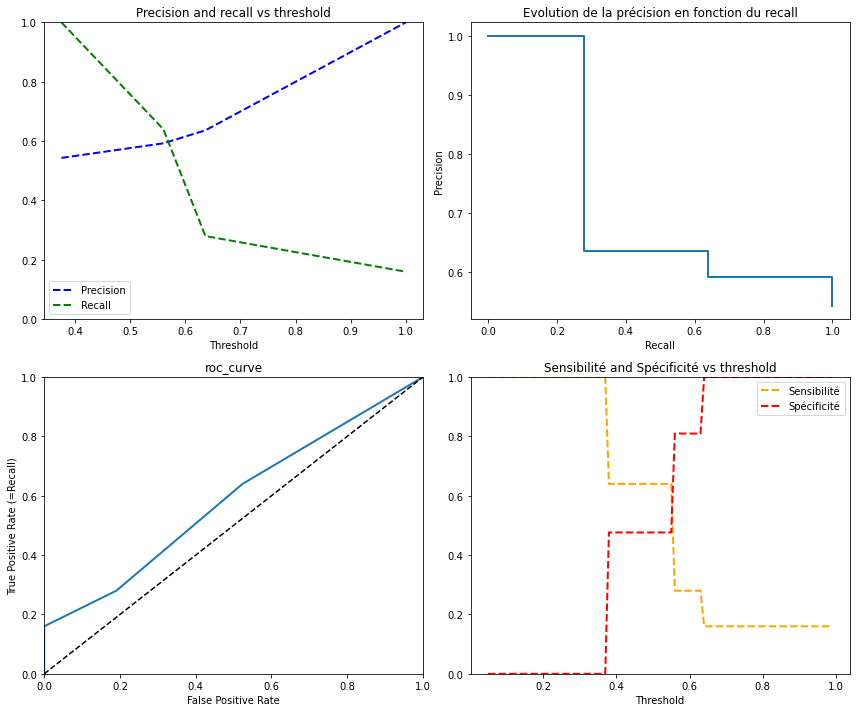

threshold = 0,5
Sensibilité :  0.64
Spécificité :  0.47619047619047616
_________________________________________________________
Best threshold : 0.56
Sensibilité : 0.28
Spécificité : 0.8095238095238095


In [42]:
RFC_speci_6_opti = RandomForestClassifier(random_state=seed)
opt_testbis6_ = BayesSearchCV(estimator=RFC_speci_6_opti, search_spaces=params_4, scoring = 'average_precision', n_iter=32, random_state=seed)
opt_testbis6_.fit(X_train_rfc.loc[:,liste_col_speci], y_train)
tree_speci_6 = RandomForestClassifier(**dict(opt_testbis6_.best_params_),random_state=seed)
tree_speci_6.fit(X_train_rfc.loc[:,liste_col_speci], y_train)
pred_speci_6 = tree_speci_6.predict(X_test_rfc.loc[:,liste_col_speci])
model_to_plot(tree_speci_6, X_test_rfc.loc[:,liste_col_speci], y_test)
resultat_speci_6 = pd.DataFrame(pd.Series(scores(y_test, pred_speci_6)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat_speci_6.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_speci_6.loc['specificité','XGB_BL_sensi'])
dict_speci_6 = from_model_to_bst_trhld(tree_speci_6, X_test_rfc.loc[:,liste_col_speci], y_test)
print('_________________________________________________________')
print('Best threshold :', dict_speci_6['best_threshold'])
print('Sensibilité :', dict_speci_6['scores']['sensibilite'])
print('Spécificité :', dict_speci_6['scores']['specificité'])

## ML mixte : 

## Base line : 

In [43]:
# Init du modèle :
RFC_mixte = RandomForestClassifier(random_state=seed)

# Préparation des datas :

mixte_RF_cv = cross_validate(RFC_mixte, X_train_rfc.loc[:,liste_col_mixte], y_train, cv=5, scoring=scorers, return_estimator =True)

print('sensi : ',round(mixte_RF_cv['test_sensi'].mean(), 2))
print('speci : ',round(mixte_RF_cv['test_speci'].mean(),2))

sensi :  0.54
speci :  0.62


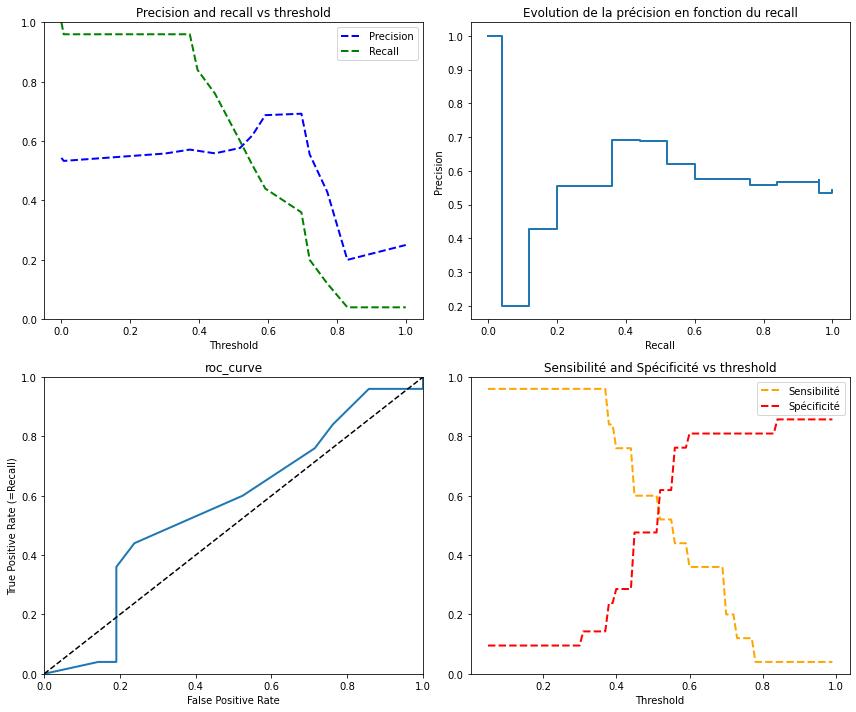

threshold = 0,5
Sensibilité :  0.6
Spécificité :  0.47619047619047616
_________________________________________________________
Best threshold : 0.6
Sensibilité : 0.36
Spécificité : 0.8095238095238095


In [44]:
RFC_mixte_ = RandomForestClassifier(random_state=seed)
RFC_mixte_.fit(X_train_rfc.loc[:,liste_col_mixte], y_train)
pred_mixte_ = RFC_mixte_.predict(X_test_rfc.loc[:,liste_col_mixte])
model_to_plot(RFC_mixte_, X_test_rfc.loc[:,liste_col_mixte], y_test)
resultat_mixte_ = pd.DataFrame(pd.Series(scores(y_test, pred_mixte_)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat_mixte_.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_mixte_.loc['specificité','XGB_BL_sensi'])
dict_mixte = from_model_to_bst_trhld(RFC_mixte_, X_test_rfc.loc[:,liste_col_mixte], y_test)
print('_________________________________________________________')
print('Best threshold :', dict_mixte['best_threshold'])
print('Sensibilité :', dict_mixte['scores']['sensibilite'])
print('Spécificité :', dict_mixte['scores']['specificité'])

### Optimisation : 

##### sensibilité : 

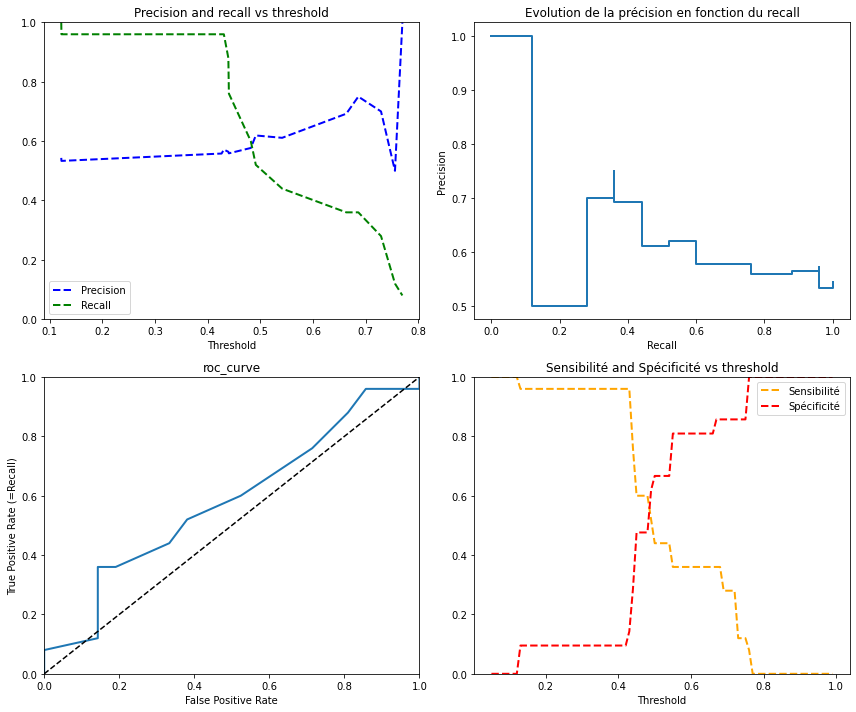

threshold = 0,5
Sensibilité :  0.44
Spécificité :  0.6666666666666666
_________________________________________________________
Best threshold : 0.67
Sensibilité : 0.36
Spécificité : 0.8571428571428571


In [46]:
RFC_mixte_1_opti = RandomForestClassifier(random_state=seed)
opt_mixte = BayesSearchCV(estimator=RFC_mixte_1_opti, search_spaces=params_4, scoring = sensibilite, n_iter=32,random_state=seed)
opt_mixte.fit(X_train_rfc.loc[:,liste_col_mixte], y_train)
tree_mixte_1 = RandomForestClassifier(**dict(opt_mixte.best_params_),random_state=seed)
tree_mixte_1.fit(X_train_rfc.loc[:,liste_col_mixte], y_train)
pred_mixte_1 = tree_mixte_1.predict(X_test_rfc.loc[:,liste_col_mixte])
model_to_plot(tree_mixte_1, X_test_rfc.loc[:,liste_col_mixte], y_test)
resultat_mixte_1 = pd.DataFrame(pd.Series(scores(y_test, pred_mixte_1)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat_mixte_1.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_mixte_1.loc['specificité','XGB_BL_sensi'])
dict_mixte_1 = from_model_to_bst_trhld(tree_mixte_1, X_test_rfc.loc[:,liste_col_mixte], y_test)
print('_________________________________________________________')
print('Best threshold :', dict_mixte_1['best_threshold'])
print('Sensibilité :', dict_mixte_1['scores']['sensibilite'])
print('Spécificité :', dict_mixte_1['scores']['specificité'])

##### Specificité : 

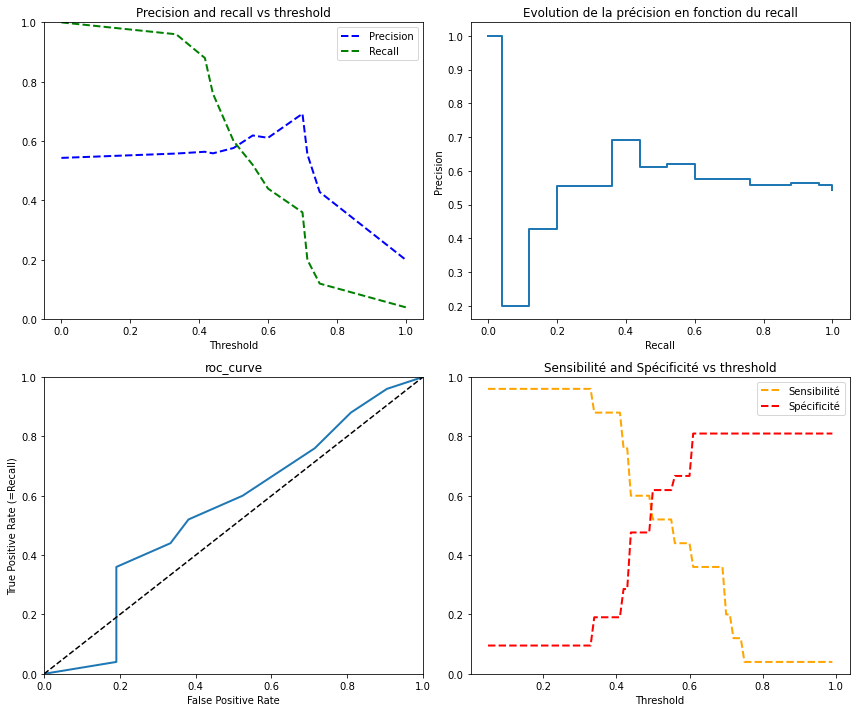

threshold = 0,5
Sensibilité :  0.52
Spécificité :  0.6190476190476191
_________________________________________________________
Best threshold : 0.61
Sensibilité : 0.36
Spécificité : 0.8095238095238095


In [47]:
RFC_mixte_2 = RandomForestClassifier(random_state=seed)
opt_mixte_2 = BayesSearchCV(estimator=RFC_mixte_2, search_spaces=params_4, scoring = specificite, n_iter=32, random_state=seed)
opt_mixte_2.fit(X_train_rfc.loc[:,liste_col_mixte], y_train)
tree_mixte_2 = RandomForestClassifier(**dict(opt_mixte_2.best_params_),random_state=seed)
tree_mixte_2.fit(X_train_rfc.loc[:,liste_col_mixte], y_train)
pred_mixte_2 = tree_mixte_2.predict(X_test_rfc.loc[:,liste_col_mixte])
model_to_plot(tree_mixte_2, X_test_rfc.loc[:,liste_col_mixte], y_test)
resultat_mixte_2 = pd.DataFrame(pd.Series(scores(y_test, pred_mixte_2)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat_mixte_2.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_mixte_2.loc['specificité','XGB_BL_sensi'])
dict_mixte_2 = from_model_to_bst_trhld(tree_mixte_2, X_test_rfc.loc[:,liste_col_mixte], y_test)
print('_________________________________________________________')
print('Best threshold :', dict_mixte_2['best_threshold'])
print('Sensibilité :', dict_mixte_2['scores']['sensibilite'])
print('Spécificité :', dict_mixte_2['scores']['specificité'])

##### F1 :

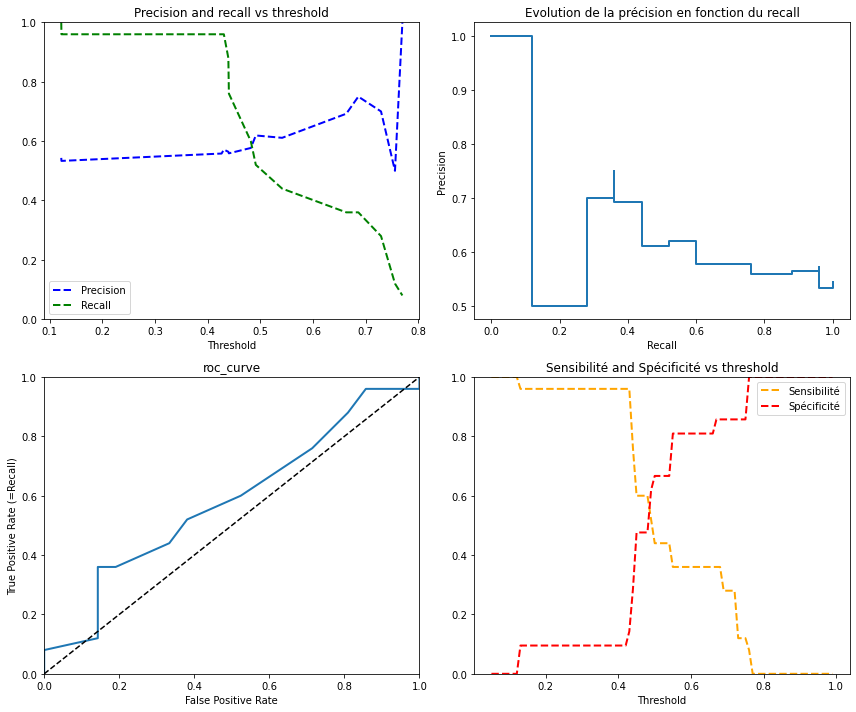

threshold = 0,5
Sensibilité :  0.44
Spécificité :  0.6666666666666666
_________________________________________________________
Best threshold : 0.67
Sensibilité : 0.36
Spécificité : 0.8571428571428571


In [48]:
RFC_mixte_3_opti = RandomForestClassifier(random_state=seed)
opt_mixte_3 = BayesSearchCV(estimator=RFC_mixte_3_opti, search_spaces=params_4, scoring = 'f1', n_iter=32, random_state=seed)
opt_mixte_3.fit(X_train_rfc.loc[:,liste_col_mixte], y_train)
tree_mixte_3 = RandomForestClassifier(**dict(opt_mixte_3.best_params_),random_state=seed)
tree_mixte_3.fit(X_train_rfc.loc[:,liste_col_mixte], y_train)
pred_mixte_3 = tree_mixte_3.predict(X_test_rfc.loc[:,liste_col_mixte])
model_to_plot(tree_mixte_3, X_test_rfc.loc[:,liste_col_mixte], y_test)
resultat_mixte_3 = pd.DataFrame(pd.Series(scores(y_test, pred_mixte_3)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat_mixte_3.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_mixte_3.loc['specificité','XGB_BL_sensi'])
dict_mixte_3 = from_model_to_bst_trhld(tree_mixte_3, X_test_rfc.loc[:,liste_col_mixte], y_test)
print('_________________________________________________________')
print('Best threshold :', dict_mixte_3['best_threshold'])
print('Sensibilité :', dict_mixte_3['scores']['sensibilite'])
print('Spécificité :', dict_mixte_3['scores']['specificité'])

##### Custom :

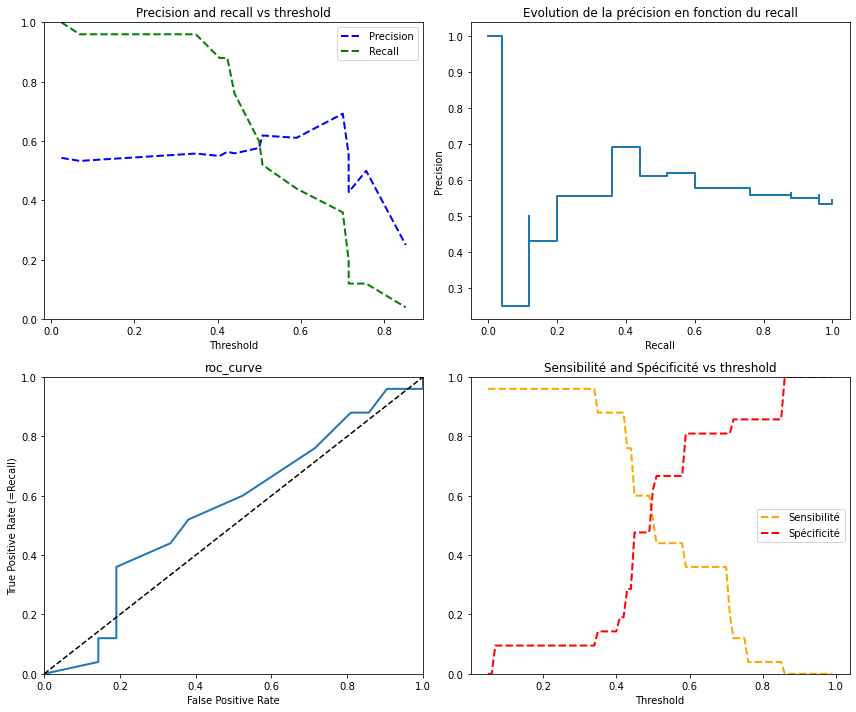

threshold = 0,5
Sensibilité :  0.52
Spécificité :  0.6190476190476191
_________________________________________________________
Best threshold : 0.59
Sensibilité : 0.36
Spécificité : 0.8095238095238095


In [49]:
RFC_mixte_4 = RandomForestClassifier(random_state=seed)
opt_mixte_4 = BayesSearchCV(estimator=RFC_mixte_4, search_spaces=params_4, scoring = scorer, n_iter=32, random_state=seed)
opt_mixte_4.fit(X_train_rfc.loc[:,liste_col_mixte], y_train)
tree_mixte_4 = RandomForestClassifier(**dict(opt_mixte_4.best_params_),random_state=seed)
tree_mixte_4.fit(X_train_rfc.loc[:,liste_col_mixte], y_train)
pred_mixte_4 = tree_mixte_4.predict(X_test_rfc.loc[:,liste_col_mixte])
model_to_plot(tree_mixte_4, X_test_rfc.loc[:,liste_col_mixte], y_test)
resultat_mixte_4 = pd.DataFrame(pd.Series(scores(y_test, pred_mixte_4)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat_mixte_4.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_mixte_4.loc['specificité','XGB_BL_sensi'])
dict_mixte_4 = from_model_to_bst_trhld(tree_mixte_4, X_test_rfc.loc[:,liste_col_mixte], y_test)
print('_________________________________________________________')
print('Best threshold :', dict_mixte_4['best_threshold'])
print('Sensibilité :', dict_mixte_4['scores']['sensibilite'])
print('Spécificité :', dict_mixte_4['scores']['specificité'])

##### Mix :

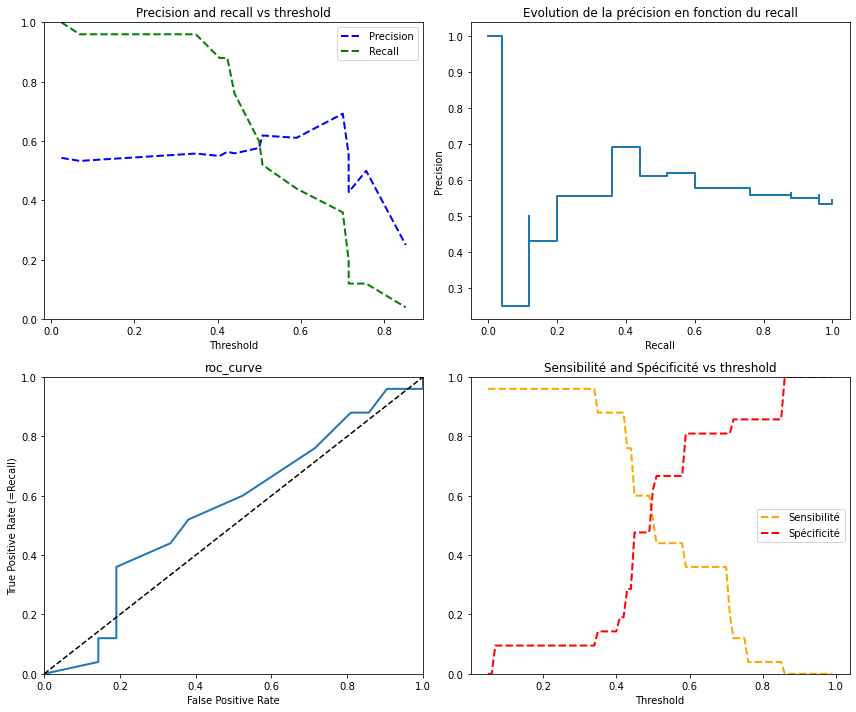

threshold = 0,5
Sensibilité :  0.52
Spécificité :  0.6190476190476191
_________________________________________________________
Best threshold : 0.59
Sensibilité : 0.36
Spécificité : 0.8095238095238095


In [50]:
RFC_mixte_5 = RandomForestClassifier(random_state=seed)
opt_mixte_5 = BayesSearchCV(estimator=RFC_mixte_5, search_spaces=params_4, scoring = mix_recall, n_iter=32,random_state=seed)
opt_mixte_5.fit(X_train_rfc.loc[:,liste_col_mixte], y_train)
tree_mixte_5 = RandomForestClassifier(**dict(opt_mixte_5.best_params_),random_state=seed)
tree_mixte_5.fit(X_train_rfc.loc[:,liste_col_mixte], y_train)
pred_mixte_5 = tree_mixte_5.predict(X_test_rfc.loc[:,liste_col_mixte])
model_to_plot(tree_mixte_5, X_test_rfc.loc[:,liste_col_mixte], y_test)
resultat_mixte_5 = pd.DataFrame(pd.Series(scores(y_test, pred_mixte_5)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat_mixte_5.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_mixte_5.loc['specificité','XGB_BL_sensi'])
dict_mixte_5 = from_model_to_bst_trhld(tree_mixte_5, X_test_rfc.loc[:,liste_col_mixte], y_test)
print('_________________________________________________________')
print('Best threshold :', dict_mixte_5['best_threshold'])
print('Sensibilité :', dict_mixte_5['scores']['sensibilite'])
print('Spécificité :', dict_mixte_5['scores']['specificité'])

##### Average precision :

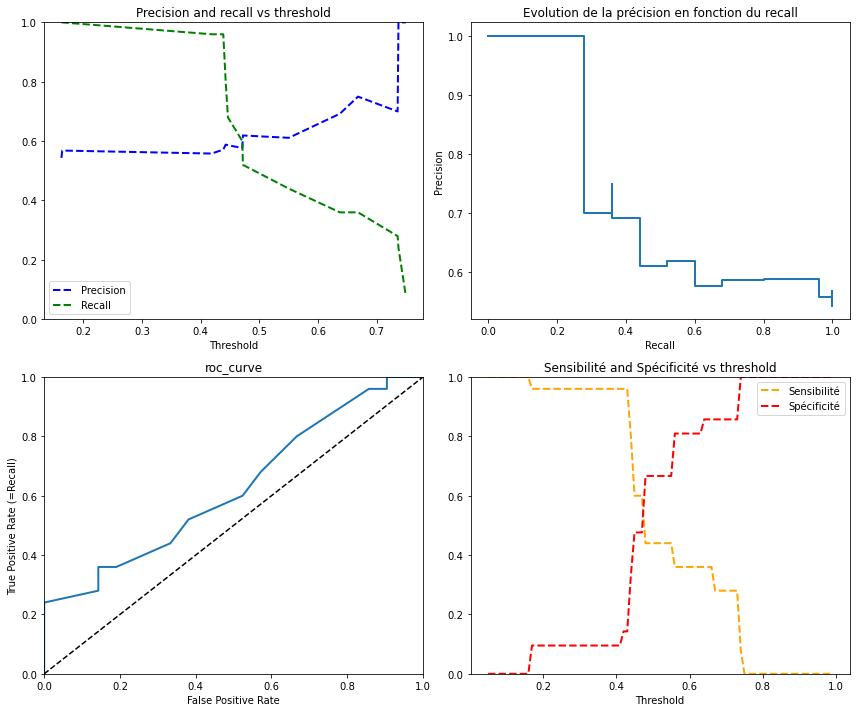

threshold = 0,5
Sensibilité :  0.44
Spécificité :  0.6666666666666666
_________________________________________________________
Best threshold : 0.64
Sensibilité : 0.36
Spécificité : 0.8571428571428571


In [51]:
RFC_mixte_6 = RandomForestClassifier(random_state=seed)
opt_mixte_6 = BayesSearchCV(estimator=RFC_mixte_6, search_spaces=params_4, scoring = 'average_precision', n_iter=32,random_state=seed)
opt_mixte_6.fit(X_train_rfc.loc[:,liste_col_mixte], y_train)
tree_mixte_6 = RandomForestClassifier(**dict(opt_mixte_6.best_params_),random_state=seed)
tree_mixte_6.fit(X_train_rfc.loc[:,liste_col_mixte], y_train)
pred_mixte_6 = tree_mixte_6.predict(X_test_rfc.loc[:,liste_col_mixte])
model_to_plot(tree_mixte_6, X_test_rfc.loc[:,liste_col_mixte], y_test)
resultat_mixte_6 = pd.DataFrame(pd.Series(scores(y_test, pred_mixte_6)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat_mixte_6.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_mixte_6.loc['specificité','XGB_BL_sensi'])
dict_mixte_6 = from_model_to_bst_trhld(tree_mixte_6, X_test_rfc.loc[:,liste_col_mixte], y_test)
print('_________________________________________________________')
print('Best threshold :', dict_mixte_6['best_threshold'])
print('Sensibilité :', dict_mixte_6['scores']['sensibilite'])
print('Spécificité :', dict_mixte_6['scores']['specificité'])

## ML speci + mixte : 

## Base line : 

In [52]:
# Init du modèle :
RFC_speci_mixte = RandomForestClassifier(random_state=seed)

# Préparation des datas :

speci_mixte_RF_cv = cross_validate(RFC_speci_mixte, X_train_rfc.loc[:,liste_col_speci+liste_col_mixte], y_train, cv=5, scoring=scorers, return_estimator =True)

print('sensi : ',round(speci_mixte_RF_cv['test_sensi'].mean(), 2))
print('speci : ',round(speci_mixte_RF_cv['test_speci'].mean(),2))

sensi :  0.53
speci :  0.56


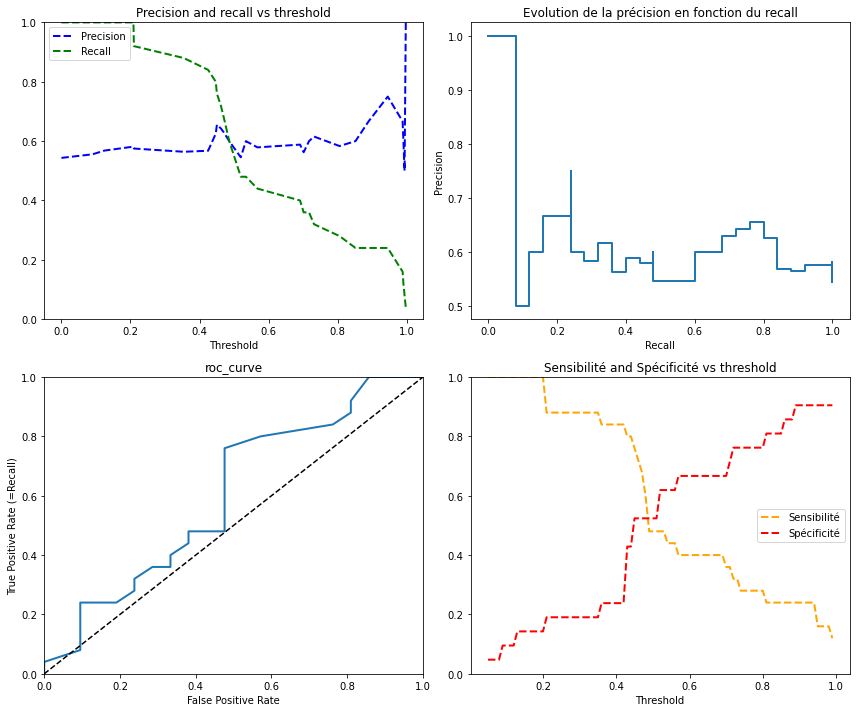

threshold = 0,5
Sensibilité :  0.48
Spécificité :  0.5238095238095238
_________________________________________________________
Best threshold : 0.89
Sensibilité : 0.24
Spécificité : 0.9047619047619048


In [53]:
RFC_mixte_speci = RandomForestClassifier(random_state=seed)
RFC_mixte_speci.fit(X_train_rfc.loc[:,liste_col_speci+liste_col_mixte], y_train)
pred_mixte_speci_ = RFC_mixte_speci.predict(X_test_rfc.loc[:,liste_col_speci+liste_col_mixte])
model_to_plot(RFC_mixte_speci, X_test_rfc.loc[:,liste_col_speci+liste_col_mixte], y_test)
resultat_mixte_speci_ = pd.DataFrame(pd.Series(scores(y_test, pred_mixte_speci_)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat_mixte_speci_.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_mixte_speci_.loc['specificité','XGB_BL_sensi'])
dict_mixte_speci_ = from_model_to_bst_trhld(RFC_mixte_speci, X_test_rfc.loc[:,liste_col_speci+liste_col_mixte], y_test)
print('_________________________________________________________')
print('Best threshold :', dict_mixte_speci_['best_threshold'])
print('Sensibilité :', dict_mixte_speci_['scores']['sensibilite'])
print('Spécificité :', dict_mixte_speci_['scores']['specificité'])

### Optimisation : 

##### sensibilité : 

In [ ]:
RFC_mixte_1_opti_sensi_mixte = RandomForestClassifier(random_state=seed)
opt_mixte_sensi = BayesSearchCV(estimator=RFC_mixte_1_opti_sensi_mixte, search_spaces=params_4, scoring = sensibilite, n_iter=32, random_state=seed)
opt_mixte_sensi.fit(X_train_rfc.loc[:,liste_col_speci+liste_col_mixte], y_train)
tree_mixte_sensi_1 = RandomForestClassifier(**dict(opt_mixte_sensi.best_params_),random_state=seed)
tree_mixte_sensi_1.fit(X_train_rfc.loc[:,liste_col_speci+liste_col_mixte], y_train)
pred_mixte_sensi_1 = tree_mixte_sensi_1.predict(X_test_rfc.loc[:,liste_col_speci+liste_col_mixte],)
model_to_plot(tree_mixte_sensi_1, X_test_rfc.loc[:,liste_col_speci+liste_col_mixte],, y_test)
resultat_mixte_speci_1 = pd.DataFrame(pd.Series(scores(y_test, pred_mixte_sensi_1)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat_mixte_speci_1.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_mixte_speci_1.loc['specificité','XGB_BL_sensi'])
dict_mixte_speci_1 = from_model_to_bst_trhld(tree_mixte_sensi_1, X_test_rfc.loc[:,liste_col_speci+liste_col_mixte],, y_test)
print('_________________________________________________________')
print('Best threshold :', dict_mixte_speci_1['best_threshold'])
print('Sensibilité :', dict_mixte_speci_1['scores']['sensibilite'])
print('Spécificité :', dict_mixte_speci_1['scores']['specificité'])

##### Specificité : 

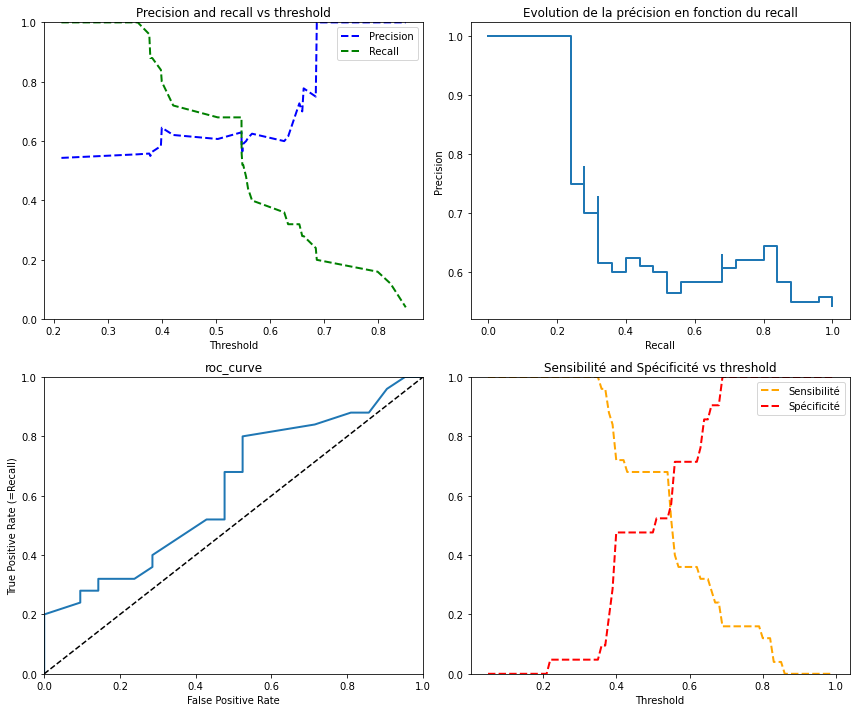

threshold = 0,5
Sensibilité :  0.68
Spécificité :  0.47619047619047616
_________________________________________________________
Best threshold : 0.64
Sensibilité : 0.32
Spécificité : 0.8571428571428571


In [56]:
RFC_mixte_sensi_2 = RandomForestClassifier(random_state=seed)
opt_mixte_sensi_2 = BayesSearchCV(estimator=RFC_mixte_sensi_2, search_spaces=params_4, scoring = specificite, n_iter=32, random_state=seed)
opt_mixte_sensi_2.fit(X_train_rfc.loc[:,liste_col_speci+liste_col_mixte], y_train)
tree_mixte_sensi_2 = RandomForestClassifier(**dict(opt_mixte_sensi_2.best_params_),random_state=seed)
tree_mixte_sensi_2.fit(X_train_rfc.loc[:,liste_col_speci+liste_col_mixte], y_train)
pred_mixte_sensi_2 = tree_mixte_sensi_2.predict(X_test_rfc.loc[:,liste_col_speci+liste_col_mixte],)
model_to_plot(tree_mixte_sensi_2, X_test_rfc.loc[:,liste_col_speci+liste_col_mixte], y_test)
resultat_mixte_sensi_2 = pd.DataFrame(pd.Series(scores(y_test, pred_mixte_sensi_2)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat_mixte_sensi_2.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_mixte_sensi_2.loc['specificité','XGB_BL_sensi'])
dict_mixte_speci_2 = from_model_to_bst_trhld(tree_mixte_sensi_2, X_test_rfc.loc[:,liste_col_speci+liste_col_mixte], y_test)
print('_________________________________________________________')
print('Best threshold :', dict_mixte_speci_2['best_threshold'])
print('Sensibilité :', dict_mixte_speci_2['scores']['sensibilite'])
print('Spécificité :', dict_mixte_speci_2['scores']['specificité'])

##### F1 :

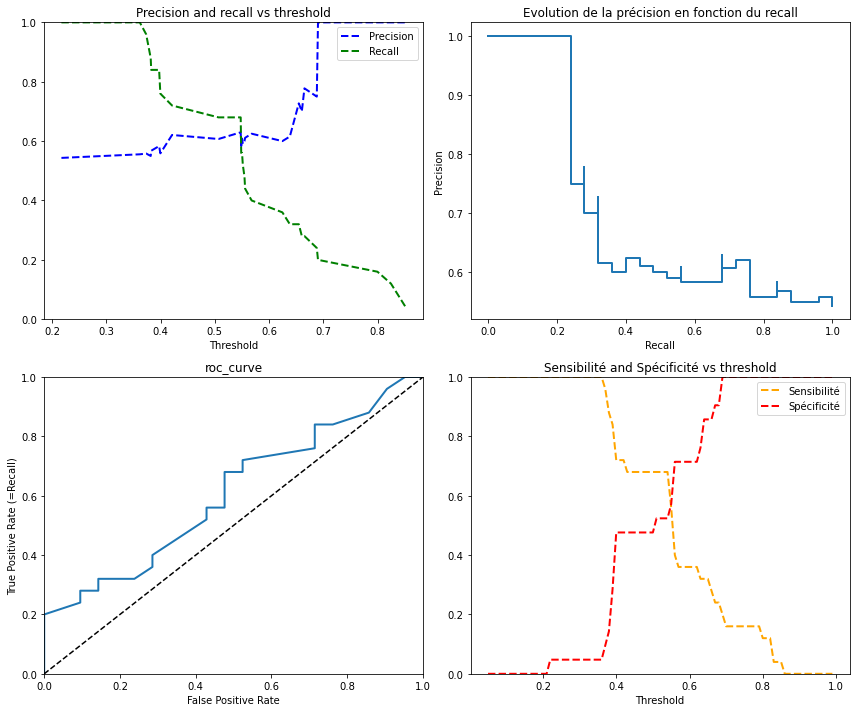

threshold = 0,5
Sensibilité :  0.68
Spécificité :  0.47619047619047616
_________________________________________________________
Best threshold : 0.64
Sensibilité : 0.32
Spécificité : 0.8571428571428571


In [57]:
RFC_mixte_3_opti_ = RandomForestClassifier(random_state=seed)
opt_mixte_sensi_3 = BayesSearchCV(estimator=RFC_mixte_3_opti_, search_spaces=params_4, scoring = 'f1', n_iter=32, random_state=seed)
opt_mixte_sensi_3.fit(X_train_rfc.loc[:,liste_col_speci+liste_col_mixte], y_train)
tree_mixte_sensi_3 = RandomForestClassifier(**dict(opt_mixte_sensi_3.best_params_),random_state=seed)
tree_mixte_sensi_3.fit(X_train_rfc.loc[:,liste_col_speci+liste_col_mixte], y_train)
pred_mixte_sensi_3 = tree_mixte_sensi_3.predict(X_test_rfc.loc[:,liste_col_speci+liste_col_mixte],)
model_to_plot(tree_mixte_sensi_3, X_test_rfc.loc[:,liste_col_speci+liste_col_mixte], y_test)
resultat_mixte_speci_3 = pd.DataFrame(pd.Series(scores(y_test, pred_mixte_sensi_3)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat_mixte_speci_3.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_mixte_speci_3.loc['specificité','XGB_BL_sensi'])
dict_mixte_speci_3 = from_model_to_bst_trhld(tree_mixte_sensi_3, X_test_rfc.loc[:,liste_col_speci+liste_col_mixte], y_test)
print('_________________________________________________________')
print('Best threshold :', dict_mixte_speci_3['best_threshold'])
print('Sensibilité :', dict_mixte_speci_3['scores']['sensibilite'])
print('Spécificité :', dict_mixte_speci_3['scores']['specificité'])

##### Custom :

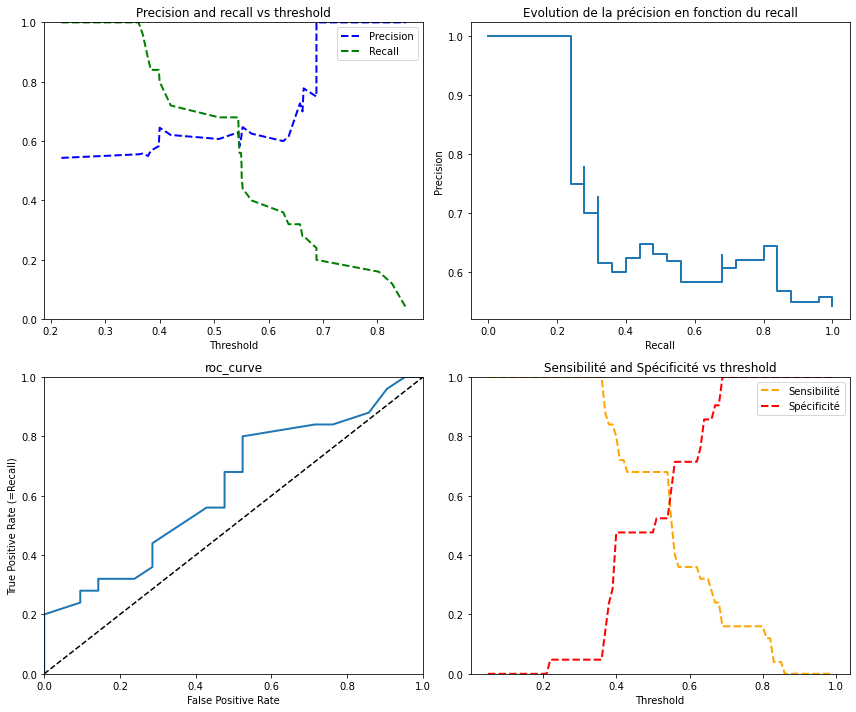

threshold = 0,5
Sensibilité :  0.68
Spécificité :  0.47619047619047616
_________________________________________________________
Best threshold : 0.64
Sensibilité : 0.32
Spécificité : 0.8571428571428571


In [60]:
RFC_mixte_4_ = RandomForestClassifier(random_state=seed)
opt_mixte_sensi_4 = BayesSearchCV(estimator=RFC_mixte_4_, search_spaces=params_4, scoring = scorer, n_iter=32, random_state=seed)
opt_mixte_sensi_4.fit(X_train_rfc.loc[:,liste_col_speci+liste_col_mixte], y_train)
tree_mixte_sensi_4 = RandomForestClassifier(**dict(opt_mixte_sensi_4.best_params_),random_state=seed)
tree_mixte_sensi_4.fit(X_train_rfc.loc[:,liste_col_speci+liste_col_mixte], y_train)
pred_mixte_sensi_4 = tree_mixte_sensi_4.predict(X_test_rfc.loc[:,liste_col_speci+liste_col_mixte],)
model_to_plot(tree_mixte_sensi_4, X_test_rfc.loc[:,liste_col_speci+liste_col_mixte], y_test)
resultat_mixte_speci_4 = pd.DataFrame(pd.Series(scores(y_test, pred_mixte_sensi_4)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat_mixte_speci_4.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_mixte_speci_4.loc['specificité','XGB_BL_sensi'])
dict_mixte_speci_4 = from_model_to_bst_trhld(tree_mixte_sensi_4, X_test_rfc.loc[:,liste_col_speci+liste_col_mixte], y_test)
print('_________________________________________________________')
print('Best threshold :', dict_mixte_speci_4['best_threshold'])
print('Sensibilité :', dict_mixte_speci_4['scores']['sensibilite'])
print('Spécificité :', dict_mixte_speci_4['scores']['specificité'])

##### Mix :

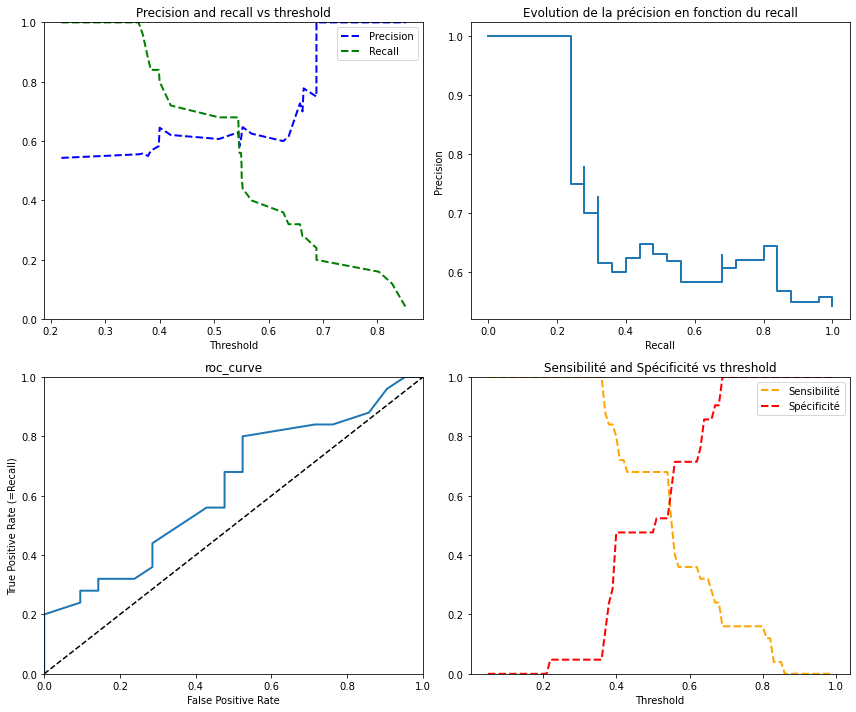

threshold = 0,5
Sensibilité :  0.68
Spécificité :  0.47619047619047616
_________________________________________________________
Best threshold : 0.64
Sensibilité : 0.32
Spécificité : 0.8571428571428571


In [58]:
RFC_mixte_5_ = RandomForestClassifier(random_state=seed)
opt_mixte_sensi_5 = BayesSearchCV(estimator=RFC_mixte_5_, search_spaces=params_4, scoring = mix_recall, n_iter=32, random_state=seed)
opt_mixte_sensi_5.fit(X_train_rfc.loc[:,liste_col_speci+liste_col_mixte], y_train)
tree_mixte_sensi_5 = RandomForestClassifier(**dict(opt_mixte_sensi_5.best_params_),random_state=seed)
tree_mixte_sensi_5.fit(X_train_rfc.loc[:,liste_col_speci+liste_col_mixte], y_train)
pred_mixte_sensi_5 = tree_mixte_sensi_5.predict(X_test_rfc.loc[:,liste_col_speci+liste_col_mixte],)
model_to_plot(tree_mixte_sensi_5, X_test_rfc.loc[:,liste_col_speci+liste_col_mixte], y_test)
resultat_mixte_speci_5 = pd.DataFrame(pd.Series(scores(y_test, pred_mixte_sensi_5)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat_mixte_speci_5.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_mixte_speci_5.loc['specificité','XGB_BL_sensi'])
dict_mixte_speci_5 = from_model_to_bst_trhld(tree_mixte_sensi_5, X_test_rfc.loc[:,liste_col_speci+liste_col_mixte], y_test)
print('_________________________________________________________')
print('Best threshold :', dict_mixte_speci_5['best_threshold'])
print('Sensibilité :', dict_mixte_speci_5['scores']['sensibilite'])
print('Spécificité :', dict_mixte_speci_5['scores']['specificité'])

##### Average_precision :

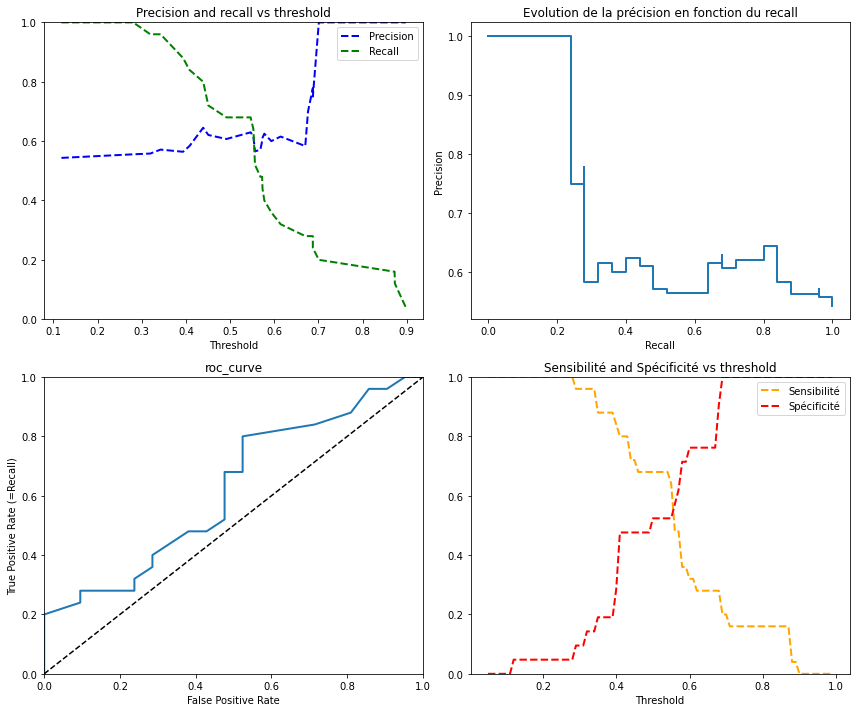

threshold = 0,5
Sensibilité :  0.68
Spécificité :  0.5238095238095238
_________________________________________________________
Best threshold : 0.68
Sensibilité : 0.28
Spécificité : 0.9047619047619048


In [59]:
RFC_mixte_5_av = RandomForestClassifier(random_state=seed)
opt_mixte_sensi_5_av = BayesSearchCV(estimator=RFC_mixte_5_av, search_spaces=params_4, scoring = 'average_precision', n_iter=32, random_state=seed)
opt_mixte_sensi_5_av.fit(X_train_rfc.loc[:,liste_col_speci+liste_col_mixte], y_train)
tree_mixte_sensi_6 = RandomForestClassifier(**dict(opt_mixte_sensi_5_av.best_params_),random_state=seed)
tree_mixte_sensi_6.fit(X_train_rfc.loc[:,liste_col_speci+liste_col_mixte], y_train)
pred_mixte_sensi_6 = tree_mixte_sensi_6.predict(X_test_rfc.loc[:,liste_col_speci+liste_col_mixte],)
model_to_plot(tree_mixte_sensi_6, X_test_rfc.loc[:,liste_col_speci+liste_col_mixte], y_test)
resultat_mixte_speci_6 = pd.DataFrame(pd.Series(scores(y_test, pred_mixte_sensi_6)), columns=['XGB_BL_sensi'])
print('threshold = 0,5')
print('Sensibilité : ', resultat_mixte_speci_6.loc['sensibilite','XGB_BL_sensi'])
print('Spécificité : ', resultat_mixte_speci_6.loc['specificité','XGB_BL_sensi'])
dict_mixte_speci_6 = from_model_to_bst_trhld(tree_mixte_sensi_6, X_test_rfc.loc[:,liste_col_speci+liste_col_mixte], y_test)
print('_________________________________________________________')
print('Best threshold :', dict_mixte_speci_6['best_threshold'])
print('Sensibilité :', dict_mixte_speci_6['scores']['sensibilite'])
print('Spécificité :', dict_mixte_speci_6['scores']['specificité'])

# fin

# A completer

## Recherche des meilleures colonnes : 

In [ ]:
def ML_opti_recueil_RF(X_train, X_test, y_train, y_test, liste_col, model_to_train, seuil_FP, seuil_FN):
    '''
    take a Train/test split and a list of column for fit a baseline ML algorithm and try to improve it, column bu column.
    input:
    X_train : training features pd.DataFrame is expected
    X_test : test features pd.DataFrame is expected
    y_train : training labels pd.DataFrame is expected
    y_test : test labels pd.DataFrame is expected
    liste_col : liste of columns from the train, will be the baseline for ML
    model_to_train
    seuil_FP
    seuil_FN
    
    Return :
    Dictionary with fitted model, metrics' results, predictions
    
    '''
    # Initi Params for BayesSearch :
    params = {
            'bootstrap': [True, False],
            'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
            'min_samples_leaf': [1, 2, 4, 5, 6, 7],
            'min_samples_split': [2, 5, 10],
            'n_estimators': [100, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
           }
    
    
    # Inputing data :
    inputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    X_train_ = inputer.fit_transform(X_train)
    X_train = pd.DataFrame(X_train_, columns=X_train.columns, index=X_train.index)
    X_test_ = inputer.transform(X_test)
    X_test = pd.DataFrame(X_test_, columns=X_test.columns, index=X_test.index)
    
    # Initialisation : 
    dict_best_set = {}
    best_results ={}
    list_columns_to_try = filtre_list(list(X_train.columns), liste_col)
    # model = RandomForest(random_state=42)
    bs = BayesSearchCV(estimator=model, search_spaces=params, scoring = 'average_precision', n_iter=32, random_state=seed)
    bs.fit(X_train.loc[:,liste_col], y_train)
    
    
    y_pred_baseline, model_baseline  = fit_method(model_to_train, X_train, X_test, y_train, liste_col)
    dict_score_baseline = scores(y_test, y_pred_baseline) 
    check_baseline(dict_score_baseline, seuil_FP, seuil_FN)
    best_set = liste_col
    best_results['results'] = dict_score_baseline
    best_results['set_col'] = best_set
    
    # Loop for optimize the ML :
    for col in list_columns_to_try:
        if check_corr_col(col, best_set)==True:
            print(len(best_set+[col]))
            y_pred, model  = fit_method(model_to_train, X_train, X_test, y_train, best_set+[col])
            dict_score = scores(y_test, y_pred)
            if check_best_results(dict_score, seuil_FP, seuil_FN): ##### TO DO !!!!!!
                best_set = best_set + [col]
                best_results['results'] = dict_score
                best_results['model'] = model
                dict_best_set[f'resultat_{len(dict_best_set.keys())}'] = {'set_col':best_set, 'resultat':dict_score, 'model':model}
        else:
            continue
    
    
    return best_results, dict_best_set, y_pred

In [ ]:
liste_test = ['atcd.chir.oma',
'atcd.chir.endo',
'atcd.pma',
'atcd.fiv',
'sf.dsp',
'tv.douleur.torus',
'echo.lusg',
'echo.rectum',
'irm.oma',
'irm.dig',
'irm.opac.vagin',
'avis.dig/uro',
'chir_CAP',
'dsp.type_aucun']

In [ ]:
best_results_RF, dict_best_set_RF, y_pred_RF = ML_opti_recueil_RF(X_train, X_test, y_train, y_test, liste_test, RandomForestClassifier(random_state=42), 3, 18)

In [ ]:
liste_anciennes_colonnes = ["atcd.chir.oma",
"atcd.chir.endo",
"atcd.pma",
"atcd.fiv",
"sf.dsp",
"tv.douleur.torus",
"echo.lusg",
"echo.rectum",
"irm.oma",
"irm.dig",
"irm.opac.vagin",
"avis.dig/uro",
"chir_CAP",
"dsp.type_aucun",
"g",
"atcd.fibrome",
"atcd.sma.douleur",
"ttt.ains",
"ttt.p1",
"ttt.p2",
"sf.dsm",
"sf.dig.diarrhee",
"sf.scap",
"sf.ombilic"]


In [ ]:
from sklearn.model_selection import cross_val_score, cross_validate

# Feature selection : 

In [ ]:
from sklearn.feature_selection import SequentialFeatureSelector